In [1]:
import numpy as np
import pandas as pd

# 时间处理
import calendar
import empyrical as ep # 风险指标计算
from alphalens.utils import print_table
from dateutil.parser import parse

import itertools # 迭代器
import collections # 容器

from tqdm import tqdm_notebook # 进度条

from jqdata import *

# 画图
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # 导入设置坐标轴的模块

plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.style.use('seaborn')

# 数据获取函数

## 数据获取

这里构造获取北流及北流持仓数据的获取函数

In [2]:
def distributed_query(query_func_name, start: str, end: str, limit=3000, **kwargs) -> pd.DataFrame:
    '''用于绕过最大条数限制'''

    days = get_trade_days(start, end)

    n_days = len(days)

    if len(days) > limit:

        n = n_days // limit

        df_list = []

        i = 0

        pos1, pos2 = n * i, n * (i + 1) - 1

        while pos2 < n_days:

            df = query_func_name(
                start=dates[pos1],
                end=dates[pos2],
                **kwargs)

            df_list.append(df)

            i += 1

            pos1, pos2 = n * i, n * (i + 1) - 1

            if pos1 < n_days:

                df = query_func_name(
                    start=dates[pos1],
                    end=dates[-1],
                    **kwargs)

                df_list.append(df)

            df = pd.concat(df_list, axis=0)

    else:

        df = query_func_name(
            start=start, end=end, **kwargs)

    return df


def query_northmoney(start: str, end: str, fields: list) -> pd.DataFrame:
    '''北向资金成交查询'''

    select_type = ['沪股通', '深股通']

    select_fields = ','.join([f"finance.STK_ML_QUOTA.%s" % i for i in fields])

    q = query(select_fields).filter(finance.STK_ML_QUOTA.day >= start,
                                    finance.STK_ML_QUOTA.day <= end,
                                    finance.STK_ML_QUOTA.link_name.in_(select_type))

    return finance.run_query(q)


def query_north_hold(start: str, end: str, fields: list) -> pd.DataFrame:
    
    '''北向持股数据查询 2017年3月17号开始至今'''

    select_type = ['沪股通', '深股通']

    select_fields = ','.join(
        [f"finance.STK_HK_HOLD_INFO.%s" % i for i in fields])

    periods = get_trade_days(start, end)

    df_list = []

    for d in tqdm_notebook(periods, desc='查询北向持股数据'):
        
        for n in select_type:
            # 构造查询
            q = query(select_fields).filter(finance.STK_HK_HOLD_INFO.link_name == n,
                                            finance.STK_HK_HOLD_INFO.day == d)

            df_list.append(finance.run_query(q))

    return pd.concat(df_list)


def is_index_cons(df: pd.DataFrame, index_symbol: list) -> pd.DataFrame:
    '''
    判断是否为指数成分股并标记
    ---------
    df 列名必须包含 |day|code|
        day类型为datetime.date
    '''

    start = min(df['day']).year
    end = max(df['day']).year

    year_list = range(start, end + 1)

    dic_list = []  # 储存调仓日

    d = collections.defaultdict(list)

    # 获取每个调仓日节点
    for y, m in itertools.product(year_list, (6, 12)):

        change_day = OffsetDate(find_change_day(y, m, 'Friday', '2nd'), 1)
        def index_name(x): return get_security_info(x).name
        dic_list += [[(code, index_name(index_code)) for code in get_index_stocks(index_code, date=change_day)]
                     for index_code in index_symbol]

    temp_list = []
    for i in dic_list:
        temp_list += i

    for k, v in temp_list:

        d[k].append(v)

    df['is_cons'] = df['code'].apply(
        lambda x: ",".join(set(d.get(x, ['OTHER']))))

    return df


# 判断某年某月的第N个周几的日期
# 比如 2019，6月的第2个周五是几号
# 中证指数基本上都是每年6\12月第二个周五的下个交易日
def find_change_day(year, month, weekday, spec_weekday):
    '''
    find_day(y, 12, "Friday", "2nd")
    ================
    return datetime.date
        y年12月第二个周五
    '''
    DAY_NAMES = [day for day in calendar.day_name]
    day_index = DAY_NAMES.index(weekday)
    possible_dates = [
        week[day_index]
        for week in calendar.monthcalendar(year, month)
        if week[day_index]]  # remove zeroes

    if spec_weekday == 'teenth':

        for day_num in possible_dates:
            if 13 <= day_num <= 19:
                return datetime.date(year, month, day_num)

    elif spec_weekday == 'last':
        day_index = -1
    elif spec_weekday == 'first':
        day_index = 0
    else:
        day_index = int(spec_weekday[0]) - 1
    return datetime.date(year, month, possible_dates[day_index])


# 基于基准日偏移
def OffsetDate(end_date: str, count: int) -> datetime.date:
    '''
    end_date:为基准日期
    count:为正则后推，负为前推
    -----------
    return datetime.date
    '''

    trade_date = get_trade_days(end_date=end_date, count=1)[0]
    if count > 0:
        # 将end_date转为交易日

        trade_cal = get_all_trade_days().tolist()

        trade_idx = trade_cal.index(trade_date)

        return trade_cal[trade_idx + count]

    elif count < 0:

        return get_trade_days(end_date=trade_date, count=abs(count))[0]

    else:

        raise ValueError('别闹！')


## 风险指标获取

这里获取回测后风险指标的获取函数

In [3]:
def get_strategy_risk(algorithm_ret) -> pd.Series:

    ser = pd.Series({'年化收益率': ep.annual_return(algorithm_ret),
                     '年化波动率': ep.annual_volatility(algorithm_ret),
                     '最大回撤': ep.max_drawdown(algorithm_ret),
                     'Sharpe': ep.sharpe_ratio(algorithm_ret),
                     '收益回撤比': ep.calmar_ratio(algorithm_ret)})

    ser.name = '风险指标'

    return ser

# 数据获取

In [27]:
start = '2014-11-17'
end = '2020-08-27'

# 获取北流相关数据 数据起始日:2014-11-17
fields = ['day', 'link_name', 'buy_amount', 'sell_amount', 'sum_amount']
north_money = distributed_query(query_northmoney, start, end, fields=fields)

# 获取北流持仓
fields = ['day', 'link_name', 'code', 'name', 'share_ratio']
north_hold = query_north_hold(start, end, fields)

# 获取上证指标
index_df = get_price('000001.XSHG', start, end, fields='close')

查询北向持股数据: 100%|██████████| 1411/1411 [01:19<00:00, 10.49it/s]


# 数据研究

北向资金向来有“聪明资金”的称号，自2014年11月沪港通首先开通起，除了 15 年股灾、 19 年中旬中美贸易摩擦升级、20 年初新冠疫情引发全球资产抛售外，其余时间段均呈现持 续净流入态势。随着 A 股国际化进程的不断深化，国内市场受借道陆股通进入的国际资本的
影响会越来越大，研究外资的动向和资金风格偏好有助于我们更好地挖掘交易机会。

In [28]:
# 日度合计各项指标
daily_northmoney = north_money.groupby('day').sum()
daily_northmoney.index = pd.to_datetime(daily_northmoney.index)

# 计算净流
net_flow = daily_northmoney['buy_amount'] - daily_northmoney['sell_amount']

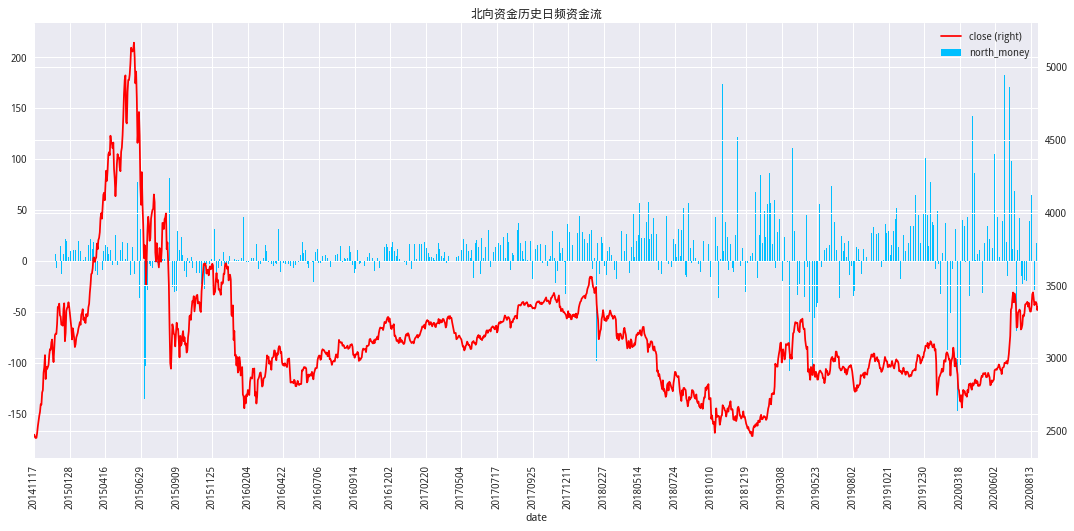

In [41]:
# 可视化
plt.rcParams['font.family'] = 'serif'
df = pd.concat([net_flow, index_df], axis=1).reset_index()
df.columns = ['date', 'north_money', 'close']
df['date'] = df['date'].dt.strftime('%Y%m%d')

line = df.plot.line(x='date', y='close', secondary_y=True,
                    color='r', figsize=(18, 8), title='北向资金历史日频资金流')
df.plot.bar(x='date', y='north_money', ax=getattr(
    line, 'left_ax', line), color='DeepSkyBlue', rot=90)


xticks = list(range(0, len(df), 50))

xlabels = df['date'].loc[xticks].values.tolist()

plt.xticks(xticks, xlabels, rotation=90);

可以看到指数成分股中互有交集

In [42]:
def get_index_dispt(north_df:pd.DataFrame,symbol:list)->pd.DataFrame:
    
    '''
    显示所持股票所属成分股
    
    df:north_hold表
    symbol:查询的指数
    '''
    # 标记个股所属成分
    df = is_index_cons(north_df, symbol)
    df['day'] = pd.to_datetime(df['day'])
    
    # 统计所持股票成分分布
    return df.groupby(pd.Grouper(key='day', freq='Q'))[
    'is_cons'].value_counts(normalize=True).unstack()

查看北向资金所持股票再主流宽基指数中的分布

In [43]:
symbol = ['000300.XSHG','000905.XSHG','399006.XSHE']
cons_label = get_index_dispt(north_hold,symbol)

# 查看数据结构
cons_label.head()

is_cons,CYBZ,"CYBZ,HS300","CYBZ,HS300,ZZ500","CYBZ,ZZ500",HS300,"HS300,ZZ500",OTHER,ZZ500
day,,,,,,,,
2017-03-31,0.030535,0.006855,0.009347,0.025550,0.135849,0.068547,0.434738,0.288579
2017-06-30,0.030708,0.006787,0.009255,0.025718,0.135801,0.068453,0.434367,0.288911
2017-09-30,0.029688,0.006407,0.008737,0.026067,0.132757,0.067566,0.445253,0.283525
2017-12-31,0.029294,0.006318,0.008418,0.026422,0.131345,0.067163,0.447979,0.283062
2018-03-31,0.029986,0.006491,0.008256,0.026409,0.127697,0.068114,0.455268,0.277780


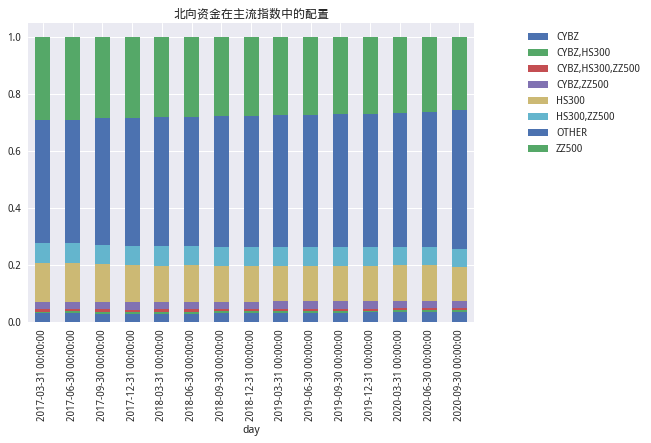

In [44]:
cons_label.plot.bar(stacked=True,title='北向资金在主流指数中的配置')
plt.legend(loc='upper left', bbox_to_anchor=(1.1,1.0))

查看北向资金所持股票在沪深两市及创业板中的分布情况

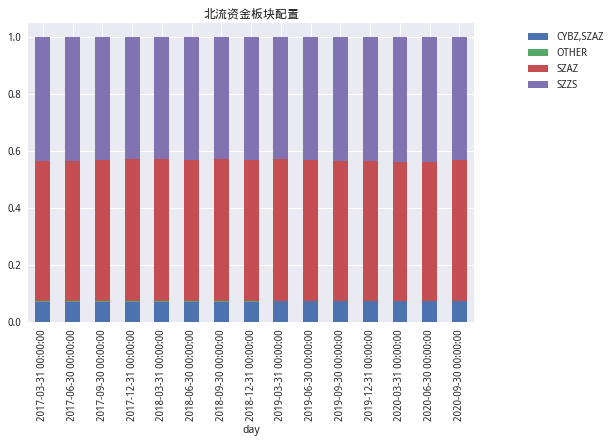

In [45]:
cons_label1 = get_index_dispt(north_hold,['000001.XSHG','399107.XSHE','399006.XSHE'])

cons_label1.plot.bar(stacked=True,title='北流资金板块配置')
plt.legend(loc='upper left', bbox_to_anchor=(1.1,1.0))

可以看到创业板所占比例在每年递增

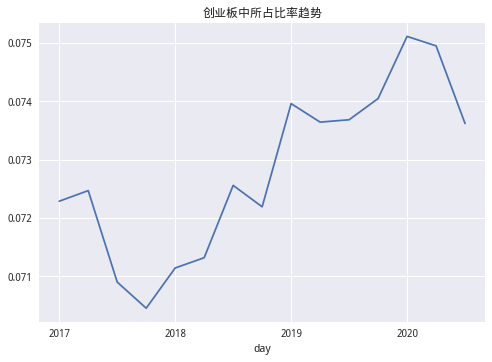

In [46]:
cons_label1['CYBZ,SZAZ'].plot.line(title='创业板中所占比率趋势')

# 择时指标建立

$$North\_Indictor_t = \frac{EMA(North\_Indictor_{t-t_{1}:t})-EMA(North\_Indictor_{t-t_{2}:t})}{std(Northflow_{t-t_{2}:t})}$$

*$North\_Indictor_{t-t_{1}:t}$代表短期时间,$North\_Indictor_{t-t_{2}:t}$代表长期时间*

在研报中对策略的构建如下：
>策略构建: 当North_Indicator指标大于阈值 Threshold_P 的时候开多，小于阈值Threshold_N的时候平仓，使用固定时点的推进分析，以 2014 年 12 月作为样本内数据的固定起点，用样本内数据
训练参数 Threshold_P 和 Threshold_N，并将模型参数用于未来 10 天。

这里我们使用sklearn接口按上面公式构建指标,并用RandomizedSearchCV进行超参寻找最优参数。

In [13]:
import talib

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


# 构造北流净值
def get_net_north_flow(start:str,end:str)->pd.Series:
    
    # 获取北流相关数据
    fields = ['day', 'link_name', 'buy_amount', 'sell_amount', 'sum_amount']
    north_money = distributed_query(query_northmoney, start, end, fields=fields)

    # 日度合计各项指标
    daily_northmoney = north_money.groupby('day').sum()
    daily_northmoney.index = pd.to_datetime(daily_northmoney.index)

    # 计算净流
    return daily_northmoney['buy_amount'] - daily_northmoney['sell_amount']


# 构造流趋势指标构建
class Northflow(TransformerMixin, BaseEstimator):

    def __init__(self, shortperiod: int, longperiod: int):

        self.shortperiod = shortperiod
        self.longperiod = longperiod

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        l = X.ewm(span=self.longperiod, adjust=False).mean()

        s = X.ewm(span=self.shortperiod, adjust=False).mean()

        north_factor = (s - l) / X.rolling(self.longperiod).std()
       

        return north_factor.dropna()

    
# 资金流策略构建
class NorthflowStrategy(BaseEstimator):

    def __init__(self, threshold_h: float, threshold_l: float):

        self.threshold_h = threshold_h
        self.threshold_l = threshold_l

    # 策略是如何训练的
    def fit(self, X, y):
        '''
        X:北流择时数据
        y:收益序列
        '''

        return self.predict(X) * y.shift(-1)

    # 策略如何进行信号生成
    def predict(self, X):
        '''X:北流择时数据'''
        flag = pd.Series(index=X.index)
        per_s = X.shift(1)

        previous_day = X.index[0]

        for trade, v in X.items():

            if v > self.threshold_h:

                flag[trade] = 1
            elif v < self.threshold_l:
                flag[trade] = 0

            else:

                flag[trade] = np.nan_to_num(flag[previous_day])

            previous_day = trade

        return flag

    # 如何判断策略是优是劣质
    def score(self, X, y):

        returns = self.fit(X, y)

        # 优化指标为： 卡玛比率 + 夏普
        # 分数越大越好
        
        risk = ep.calmar_ratio(returns) + ep.sharpe_ratio(returns)
        
        return risk

## 超参

以下用2017至2020-08-27的整段时间进行超参,在整个数据集中寻找最优的参数后进行回测,这样肯定存在过拟,我们后续通过滚动解决此问题。可以看到使用sklearn接口可以很方便的进行超参寻找最优参数。

In [14]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

# 回测时间设置
start = '2017-01-01'
end = '2020-08-27'

# 获取北流数据
net_flow = get_net_north_flow(start,end)

# 基准
index_df = get_price('000300.XSHG', start, end, fields='close')

ret_ser = index_df['close'].pct_change().reindex(net_flow.index)

# 构造PIPELINE
north_factor = Pipeline([('creatfactor', Northflow(5, 10)),
                         ('backtesting', NorthflowStrategy(0.2, -0.1))])

# 寻参范围设置
## 阈值
norm_rv = st.norm(loc=-0.5, scale=0.45)
## north_indictor参数 ema计算周期从3至100
randint = st.randint(low=3, high=100)


# 超参设置
param_grid = {'creatfactor__shortperiod': randint,
              'creatfactor__longperiod': randint,
              'backtesting__threshold_h': norm_rv,
              'backtesting__threshold_l': norm_rv}


grid_search = RandomizedSearchCV(
    north_factor, param_grid, n_iter=400, verbose=2, n_jobs=3,random_state=42)

grid_search.fit(net_flow, ret_ser)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[CV] backtesting__threshold_h=-0.2764786311449453, backtesting__threshold_l=-0.5622189355270331, creatfactor__longperiod=74, creatfactor__shortperiod=63 
[CV] backtesting__threshold_h=-0.2764786311449453, backtesting__threshold_l=-0.5622189355270331, creatfactor__longperiod=74, creatfactor__shortperiod=63 
[CV] backtesting__threshold_h=-0.2764786311449453, backtesting__threshold_l=-0.5622189355270331, creatfactor__longperiod=74, creatfactor__shortperiod=63 
[CV]  backtesting__threshold_h=-0.2764786311449453, backtesting__threshold_l=-0.5622189355270331, creatfactor__longperiod=74, creatfactor__shortperiod=63, total=   0.0s
[CV] backtesting__threshold_h=-1.03901289194928, backtesting__threshold_l=0.4637462944974756, creatfactor__longperiod=89, creatfactor__shortperiod=77 
[CV]  backtesting__threshold_h=-0.2764786311449453, backtesting__threshold_l=-0.5622189355270331, creatfactor__longperiod=74, creatfactor__shortperiod=63,

[CV]  backtesting__threshold_h=0.01045266947614465, backtesting__threshold_l=-0.5471354967369944, creatfactor__longperiod=9, creatfactor__shortperiod=23, total=   0.0s
[CV] backtesting__threshold_h=0.01045266947614465, backtesting__threshold_l=-0.5471354967369944, creatfactor__longperiod=9, creatfactor__shortperiod=23 
[CV]  backtesting__threshold_h=-0.6320296158613978, backtesting__threshold_l=-0.513427356211887, creatfactor__longperiod=91, creatfactor__shortperiod=62, total=   0.0s
[CV] backtesting__threshold_h=-1.4120238270785415, backtesting__threshold_l=0.0037406252028269193, creatfactor__longperiod=92, creatfactor__shortperiod=55 
[CV]  backtesting__threshold_h=-0.83708443554951, backtesting__threshold_l=-0.8502719031909024, creatfactor__longperiod=62, creatfactor__shortperiod=73, total=   0.0s
[CV] backtesting__threshold_h=-0.83708443554951, backtesting__threshold_l=-0.8502719031909024, creatfactor__longperiod=62, creatfactor__shortperiod=73 
[CV]  backtesting__threshold_h=-1.41

[CV] backtesting__threshold_h=-0.2926326649331131, backtesting__threshold_l=-0.4613344377661335, creatfactor__longperiod=62, creatfactor__shortperiod=43 
[CV]  backtesting__threshold_h=-1.3440545474929326, backtesting__threshold_l=-1.115051962498834, creatfactor__longperiod=10, creatfactor__shortperiod=90, total=   0.0s
[CV] backtesting__threshold_h=-1.3440545474929326, backtesting__threshold_l=-1.115051962498834, creatfactor__longperiod=10, creatfactor__shortperiod=90 
[CV]  backtesting__threshold_h=-0.9033508324081858, backtesting__threshold_l=-0.5503945192281237, creatfactor__longperiod=25, creatfactor__shortperiod=64, total=   0.0s
[CV] backtesting__threshold_h=-0.9033508324081858, backtesting__threshold_l=-0.5503945192281237, creatfactor__longperiod=25, creatfactor__shortperiod=64 
[CV]  backtesting__threshold_h=-0.2926326649331131, backtesting__threshold_l=-0.4613344377661335, creatfactor__longperiod=62, creatfactor__shortperiod=43, total=   0.0s
[CV] backtesting__threshold_h=-0.

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.4199903598189616, backtesting__threshold_l=-0.018733601211381345, creatfactor__longperiod=49, creatfactor__shortperiod=80, total=   0.0s
[CV] backtesting__threshold_h=-1.4199903598189616, backtesting__threshold_l=-0.018733601211381345, creatfactor__longperiod=49, creatfactor__shortperiod=80 
[CV]  backtesting__threshold_h=-0.08123701965300412, backtesting__threshold_l=-0.1950046656469963, creatfactor__longperiod=7, creatfactor__shortperiod=43, total=   0.0s
[CV] backtesting__threshold_h=-0.08123701965300412, backtesting__threshold_l=-0.1950046656469963, creatfactor__longperiod=7, creatfactor__shortperiod=43 
[CV]  backtesting__threshold_h=0.030872355115315386, backtesting__threshold_l=-0.9041935727550552, creatfactor__longperiod=88, creatfactor__shortperiod=93, total=   0.1s
[CV] backtesting__threshold_h=0.030872355115315386, backtesting__threshold_l=-0.9041935727550552, creatfactor__longperiod=88, creatfactor__shortperiod=93 
[CV]  backtesting__thresh

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.2894923610315817, backtesting__threshold_l=-0.168744942198834, creatfactor__longperiod=16, creatfactor__shortperiod=29, total=   0.0s
[CV] backtesting__threshold_h=-0.2894923610315817, backtesting__threshold_l=-0.168744942198834, creatfactor__longperiod=16, creatfactor__shortperiod=29 
[CV]  backtesting__threshold_h=-1.678885296840385, backtesting__threshold_l=-0.13014387303114927, creatfactor__longperiod=44, creatfactor__shortperiod=79, total=   0.0s
[CV] backtesting__threshold_h=-1.678885296840385, backtesting__threshold_l=-0.13014387303114927, creatfactor__longperiod=44, creatfactor__shortperiod=79 
[CV]  backtesting__threshold_h=0.030872355115315386, backtesting__threshold_l=-0.9041935727550552, creatfactor__longperiod=88, creatfactor__shortperiod=93, total=   0.1s
[CV] backtesting__threshold_h=0.030872355115315386, backtesting__threshold_l=-0.9041935727550552, creatfactor__longperiod=88, creatfactor__shortperiod=93 
[CV]  backtesting__threshold_h=

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.43227991485023254, backtesting__threshold_l=-0.5510395631058773, creatfactor__longperiod=54, creatfactor__shortperiod=98, total=   0.0s
[CV] backtesting__threshold_h=-0.43227991485023254, backtesting__threshold_l=-0.5510395631058773, creatfactor__longperiod=54, creatfactor__shortperiod=98 
[CV]  backtesting__threshold_h=-0.8519215218349278, backtesting__threshold_l=-0.30922561859407965, creatfactor__longperiod=17, creatfactor__shortperiod=45, total=   0.0s
[CV] backtesting__threshold_h=-0.8519215218349278, backtesting__threshold_l=-0.30922561859407965, creatfactor__longperiod=17, creatfactor__shortperiod=45 
[CV]  backtesting__threshold_h=0.030872355115315386, backtesting__threshold_l=-0.9041935727550552, creatfactor__longperiod=88, creatfactor__shortperiod=93, total=   0.1s
[CV] backtesting__threshold_h=-1.1601355483307867, backtesting__threshold_l=-0.09831673782222705, creatfactor__longperiod=8, creatfactor__shortperiod=30 
[CV]  backtesting__thresho

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.7383920916951675, backtesting__threshold_l=-0.26902965509898974, creatfactor__longperiod=32, creatfactor__shortperiod=64, total=   0.0s
[CV] backtesting__threshold_h=-0.7383920916951675, backtesting__threshold_l=-0.26902965509898974, creatfactor__longperiod=32, creatfactor__shortperiod=64 
[CV]  backtesting__threshold_h=0.11733796009739939, backtesting__threshold_l=-0.4210010177203253, creatfactor__longperiod=94, creatfactor__shortperiod=91, total=   0.1s
[CV] backtesting__threshold_h=0.11733796009739939, backtesting__threshold_l=-0.4210010177203253, creatfactor__longperiod=94, creatfactor__shortperiod=91 
[CV]  backtesting__threshold_h=0.2303142247036183, backtesting__threshold_l=-0.12932011536118637, creatfactor__longperiod=30, creatfactor__shortperiod=68, total=   0.1s
[CV] backtesting__threshold_h=0.2303142247036183, backtesting__threshold_l=-0.12932011536118637, creatfactor__longperiod=30, creatfactor__shortperiod=68 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.7383920916951675, backtesting__threshold_l=-0.26902965509898974, creatfactor__longperiod=32, creatfactor__shortperiod=64, total=   0.0s
[CV] backtesting__threshold_h=-0.8916372295524833, backtesting__threshold_l=-0.7279894488341857, creatfactor__longperiod=29, creatfactor__shortperiod=11 
[CV]  backtesting__threshold_h=0.2303142247036183, backtesting__threshold_l=-0.12932011536118637, creatfactor__longperiod=30, creatfactor__shortperiod=68, total=   0.0s
[CV]  backtesting__threshold_h=0.11733796009739939, backtesting__threshold_l=-0.4210010177203253, creatfactor__longperiod=94, creatfactor__shortperiod=91, total=   0.0s
[CV] backtesting__threshold_h=-0.5725785702497042, backtesting__threshold_l=-0.31817711443345775, creatfactor__longperiod=98, creatfactor__shortperiod=90 
[CV] backtesting__threshold_h=0.11733796009739939, backtesting__threshold_l=-0.4210010177203253, creatfactor__longperiod=94, creatfactor__shortperiod=91 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.5725785702497042, backtesting__threshold_l=-0.31817711443345775, creatfactor__longperiod=98, creatfactor__shortperiod=90, total=   0.0s
[CV] backtesting__threshold_h=-0.5725785702497042, backtesting__threshold_l=-0.31817711443345775, creatfactor__longperiod=98, creatfactor__shortperiod=90 
[CV]  backtesting__threshold_h=-0.8916372295524833, backtesting__threshold_l=-0.7279894488341857, creatfactor__longperiod=29, creatfactor__shortperiod=11, total=   0.0s
[CV] backtesting__threshold_h=-0.8916372295524833, backtesting__threshold_l=-0.7279894488341857, creatfactor__longperiod=29, creatfactor__shortperiod=11 
[CV]  backtesting__threshold_h=-0.5725785702497042, backtesting__threshold_l=-0.31817711443345775, creatfactor__longperiod=98, creatfactor__shortperiod=90, total=   0.0s
[CV] backtesting__threshold_h=-0.9243755638102681, backtesting__threshold_l=0.13178143239668216, creatfactor__longperiod=60, creatfactor__shortperiod=54 
[CV]  backtesting__threshold

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.8159238922448087, backtesting__threshold_l=-0.6474479659689957, creatfactor__longperiod=29, creatfactor__shortperiod=64, total=   0.0s
[CV]  backtesting__threshold_h=-0.9243755638102681, backtesting__threshold_l=0.13178143239668216, creatfactor__longperiod=60, creatfactor__shortperiod=54, total=   0.0s
[CV] backtesting__threshold_h=-0.8159238922448087, backtesting__threshold_l=-0.6474479659689957, creatfactor__longperiod=29, creatfactor__shortperiod=64 
[CV] backtesting__threshold_h=-0.1319569195025458, backtesting__threshold_l=-0.9745720112600769, creatfactor__longperiod=5, creatfactor__shortperiod=58 
[CV]  backtesting__threshold_h=0.37530202651905364, backtesting__threshold_l=-0.5690014058822632, creatfactor__longperiod=46, creatfactor__shortperiod=26, total=   0.0s
[CV] backtesting__threshold_h=0.37530202651905364, backtesting__threshold_l=-0.5690014058822632, creatfactor__longperiod=46, creatfactor__shortperiod=26 
[CV]  backtesting__threshold_h=-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.5865624341515051, backtesting__threshold_l=-0.3643036959498744, creatfactor__longperiod=4, creatfactor__shortperiod=55, total=   0.0s
[CV] backtesting__threshold_h=-0.5865624341515051, backtesting__threshold_l=-0.3643036959498744, creatfactor__longperiod=4, creatfactor__shortperiod=55 
[CV]  backtesting__threshold_h=0.37530202651905364, backtesting__threshold_l=-0.5690014058822632, creatfactor__longperiod=46, creatfactor__shortperiod=26, total=   0.0s
[CV] backtesting__threshold_h=0.37530202651905364, backtesting__threshold_l=-0.5690014058822632, creatfactor__longperiod=46, creatfactor__shortperiod=26 
[CV]  backtesting__threshold_h=-0.1319569195025458, backtesting__threshold_l=-0.9745720112600769, creatfactor__longperiod=5, creatfactor__shortperiod=58, total=   0.1s
[CV] backtesting__threshold_h=-0.1319569195025458, backtesting__threshold_l=-0.9745720112600769, creatfactor__longperiod=5, creatfactor__shortperiod=58 
[CV]  backtesting__threshold_h=-0.5

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.5865624341515051, backtesting__threshold_l=-0.3643036959498744, creatfactor__longperiod=4, creatfactor__shortperiod=55, total=   0.0s
[CV] backtesting__threshold_h=-0.3470805661160103, backtesting__threshold_l=-0.5033210674750579, creatfactor__longperiod=34, creatfactor__shortperiod=70 
[CV]  backtesting__threshold_h=-0.1319569195025458, backtesting__threshold_l=-0.9745720112600769, creatfactor__longperiod=5, creatfactor__shortperiod=58, total=   0.0s
[CV] backtesting__threshold_h=-0.45394354285264993, backtesting__threshold_l=-0.694674176246606, creatfactor__longperiod=4, creatfactor__shortperiod=94 
[CV]  backtesting__threshold_h=0.37530202651905364, backtesting__threshold_l=-0.5690014058822632, creatfactor__longperiod=46, creatfactor__shortperiod=26, total=   0.0s
[CV] backtesting__threshold_h=-0.5964460174652868, backtesting__threshold_l=-0.8101373947089103, creatfactor__longperiod=19, creatfactor__shortperiod=40 
[CV]  backtesting__threshold_h=-0.

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.8962883683383962, backtesting__threshold_l=-0.46539727313694285, creatfactor__longperiod=99, creatfactor__shortperiod=75, total=   0.0s
[CV] backtesting__threshold_h=-0.8962883683383962, backtesting__threshold_l=-0.46539727313694285, creatfactor__longperiod=99, creatfactor__shortperiod=75 
[CV]  backtesting__threshold_h=0.1312574399212446, backtesting__threshold_l=-1.1308329782565263, creatfactor__longperiod=72, creatfactor__shortperiod=88, total=   0.0s
[CV]  backtesting__threshold_h=0.26797222915530794, backtesting__threshold_l=-0.10688476296407934, creatfactor__longperiod=21, creatfactor__shortperiod=92, total=   0.0s
[CV] backtesting__threshold_h=0.1312574399212446, backtesting__threshold_l=-1.1308329782565263, creatfactor__longperiod=72, creatfactor__shortperiod=88 
[CV] backtesting__threshold_h=0.26797222915530794, backtesting__threshold_l=-0.10688476296407934, creatfactor__longperiod=21, creatfactor__shortperiod=92 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.26797222915530794, backtesting__threshold_l=-0.10688476296407934, creatfactor__longperiod=21, creatfactor__shortperiod=92, total=   0.0s
[CV] backtesting__threshold_h=0.26797222915530794, backtesting__threshold_l=-0.10688476296407934, creatfactor__longperiod=21, creatfactor__shortperiod=92 
[CV]  backtesting__threshold_h=-0.9457413463088098, backtesting__threshold_l=-0.7548339783212474, creatfactor__longperiod=95, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=-0.9457413463088098, backtesting__threshold_l=-0.7548339783212474, creatfactor__longperiod=95, creatfactor__shortperiod=5 
[CV]  backtesting__threshold_h=0.1312574399212446, backtesting__threshold_l=-1.1308329782565263, creatfactor__longperiod=72, creatfactor__shortperiod=88, total=   0.0s
[CV] backtesting__threshold_h=0.1312574399212446, backtesting__threshold_l=-1.1308329782565263, creatfactor__longperiod=72, creatfactor__shortperiod=88 
[CV]  backtesting__threshold_h=-0

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.26797222915530794, backtesting__threshold_l=-0.10688476296407934, creatfactor__longperiod=21, creatfactor__shortperiod=92, total=   0.1s
[CV] backtesting__threshold_h=-1.1977985439797596, backtesting__threshold_l=-0.4691466613372877, creatfactor__longperiod=98, creatfactor__shortperiod=73 
[CV]  backtesting__threshold_h=-0.2586487854280706, backtesting__threshold_l=-0.9116109190675749, creatfactor__longperiod=41, creatfactor__shortperiod=84, total=   0.0s
[CV] backtesting__threshold_h=-0.2586487854280706, backtesting__threshold_l=-0.9116109190675749, creatfactor__longperiod=41, creatfactor__shortperiod=84 
[CV]  backtesting__threshold_h=0.1312574399212446, backtesting__threshold_l=-1.1308329782565263, creatfactor__longperiod=72, creatfactor__shortperiod=88, total=   0.0s
[CV] backtesting__threshold_h=-0.4074574396969982, backtesting__threshold_l=-1.1495675082633074, creatfactor__longperiod=44, creatfactor__shortperiod=9 
[CV]  backtesting__threshold_h=-

[CV] backtesting__threshold_h=-0.20612826002760765, backtesting__threshold_l=-0.003790640541779744, creatfactor__longperiod=91, creatfactor__shortperiod=27 
[CV]  backtesting__threshold_h=-0.2651262954723961, backtesting__threshold_l=-0.36635689704506624, creatfactor__longperiod=26, creatfactor__shortperiod=56, total=   0.0s
[CV] backtesting__threshold_h=-0.2651262954723961, backtesting__threshold_l=-0.36635689704506624, creatfactor__longperiod=26, creatfactor__shortperiod=56 
[CV]  backtesting__threshold_h=-0.20612826002760765, backtesting__threshold_l=-0.003790640541779744, creatfactor__longperiod=91, creatfactor__shortperiod=27, total=   0.0s
[CV] backtesting__threshold_h=0.021368010553331818, backtesting__threshold_l=-0.8693070432582697, creatfactor__longperiod=10, creatfactor__shortperiod=9 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.2651262954723961, backtesting__threshold_l=-0.36635689704506624, creatfactor__longperiod=26, creatfactor__shortperiod=56, total=   0.1s
[CV] backtesting__threshold_h=0.5230053211078669, backtesting__threshold_l=-0.43386140729425265, creatfactor__longperiod=24, creatfactor__shortperiod=32 
[CV]  backtesting__threshold_h=0.3395985300151405, backtesting__threshold_l=-0.2867751855896956, creatfactor__longperiod=82, creatfactor__shortperiod=63, total=   0.1s
[CV] backtesting__threshold_h=0.3395985300151405, backtesting__threshold_l=-0.2867751855896956, creatfactor__longperiod=82, creatfactor__shortperiod=63 
[CV]  backtesting__threshold_h=0.021368010553331818, backtesting__threshold_l=-0.8693070432582697, creatfactor__longperiod=10, creatfactor__shortperiod=9, total=   0.1s
[CV] backtesting__threshold_h=0.021368010553331818, backtesting__threshold_l=-0.8693070432582697, creatfactor__longperiod=10, creatfactor__shortperiod=9 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.3395985300151405, backtesting__threshold_l=-0.2867751855896956, creatfactor__longperiod=82, creatfactor__shortperiod=63, total=   0.1s
[CV] backtesting__threshold_h=0.3395985300151405, backtesting__threshold_l=-0.2867751855896956, creatfactor__longperiod=82, creatfactor__shortperiod=63 
[CV]  backtesting__threshold_h=0.021368010553331818, backtesting__threshold_l=-0.8693070432582697, creatfactor__longperiod=10, creatfactor__shortperiod=9, total=   0.0s
[CV] backtesting__threshold_h=0.021368010553331818, backtesting__threshold_l=-0.8693070432582697, creatfactor__longperiod=10, creatfactor__shortperiod=9 
[CV]  backtesting__threshold_h=0.5230053211078669, backtesting__threshold_l=-0.43386140729425265, creatfactor__longperiod=24, creatfactor__shortperiod=32, total=   0.1s
[CV] backtesting__threshold_h=0.5230053211078669, backtesting__threshold_l=-0.43386140729425265, creatfactor__longperiod=24, creatfactor__shortperiod=32 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.3395985300151405, backtesting__threshold_l=-0.2867751855896956, creatfactor__longperiod=82, creatfactor__shortperiod=63, total=   0.1s
[CV] backtesting__threshold_h=-0.16947452080397946, backtesting__threshold_l=-0.9295237678826392, creatfactor__longperiod=35, creatfactor__shortperiod=16 
[CV]  backtesting__threshold_h=-0.16947452080397946, backtesting__threshold_l=-0.9295237678826392, creatfactor__longperiod=35, creatfactor__shortperiod=16, total=   0.0s


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.16947452080397946, backtesting__threshold_l=-0.9295237678826392, creatfactor__longperiod=35, creatfactor__shortperiod=16 
[CV]  backtesting__threshold_h=0.021368010553331818, backtesting__threshold_l=-0.8693070432582697, creatfactor__longperiod=10, creatfactor__shortperiod=9, total=   0.1s
[CV] backtesting__threshold_h=-0.9319525844512578, backtesting__threshold_l=-0.0027823016974328207, creatfactor__longperiod=50, creatfactor__shortperiod=78 
[CV]  backtesting__threshold_h=0.5230053211078669, backtesting__threshold_l=-0.43386140729425265, creatfactor__longperiod=24, creatfactor__shortperiod=32, total=   0.1s
[CV] backtesting__threshold_h=0.5230053211078669, backtesting__threshold_l=-0.43386140729425265, creatfactor__longperiod=24, creatfactor__shortperiod=32 
[CV]  backtesting__threshold_h=-0.9319525844512578, backtesting__threshold_l=-0.0027823016974328207, creatfactor__longperiod=50, creatfactor__shortperiod=78, total=   0.0s
[CV] backtesting__thresh

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.16947452080397946, backtesting__threshold_l=-0.9295237678826392, creatfactor__longperiod=35, creatfactor__shortperiod=16, total=   0.0s
[CV] backtesting__threshold_h=0.04422188680898531, backtesting__threshold_l=-0.25791799833860196, creatfactor__longperiod=32, creatfactor__shortperiod=99 
[CV]  backtesting__threshold_h=-0.9319525844512578, backtesting__threshold_l=-0.0027823016974328207, creatfactor__longperiod=50, creatfactor__shortperiod=78, total=   0.0s
[CV] backtesting__threshold_h=0.7527721209204266, backtesting__threshold_l=-0.5140340591750798, creatfactor__longperiod=66, creatfactor__shortperiod=51 
[CV]  backtesting__threshold_h=0.5230053211078669, backtesting__threshold_l=-0.43386140729425265, creatfactor__longperiod=24, creatfactor__shortperiod=32, total=   0.0s
[CV] backtesting__threshold_h=-0.5346957692363469, backtesting__threshold_l=-0.3464816113325102, creatfactor__longperiod=56, creatfactor__shortperiod=10 
[CV]  backtesting__threshol

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.04422188680898531, backtesting__threshold_l=-0.25791799833860196, creatfactor__longperiod=32, creatfactor__shortperiod=99, total=   0.0s
[CV] backtesting__threshold_h=0.04422188680898531, backtesting__threshold_l=-0.25791799833860196, creatfactor__longperiod=32, creatfactor__shortperiod=99 
[CV]  backtesting__threshold_h=-0.5346957692363469, backtesting__threshold_l=-0.3464816113325102, creatfactor__longperiod=56, creatfactor__shortperiod=10, total=   0.0s
[CV] backtesting__threshold_h=-0.5346957692363469, backtesting__threshold_l=-0.3464816113325102, creatfactor__longperiod=56, creatfactor__shortperiod=10 
[CV]  backtesting__threshold_h=0.7527721209204266, backtesting__threshold_l=-0.5140340591750798, creatfactor__longperiod=66, creatfactor__shortperiod=51, total=   0.0s
[CV] backtesting__threshold_h=0.7527721209204266, backtesting__threshold_l=-0.5140340591750798, creatfactor__longperiod=66, creatfactor__shortperiod=51 
[CV]  backtesting__threshold_h=

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.5558595749967468, backtesting__threshold_l=-0.16684663192351767, creatfactor__longperiod=55, creatfactor__shortperiod=97, total=   0.0s
[CV] backtesting__threshold_h=-0.5558595749967468, backtesting__threshold_l=-0.16684663192351767, creatfactor__longperiod=55, creatfactor__shortperiod=97 
[CV]  backtesting__threshold_h=0.7527721209204266, backtesting__threshold_l=-0.5140340591750798, creatfactor__longperiod=66, creatfactor__shortperiod=51, total=   0.1s
[CV] backtesting__threshold_h=0.7527721209204266, backtesting__threshold_l=-0.5140340591750798, creatfactor__longperiod=66, creatfactor__shortperiod=51 
[CV]  backtesting__threshold_h=-0.5558595749967468, backtesting__threshold_l=-0.16684663192351767, creatfactor__longperiod=55, creatfactor__shortperiod=97, total=   0.0s
[CV] backtesting__threshold_h=-0.8810571731307822, backtesting__threshold_l=-1.181681251108639, creatfactor__longperiod=89, creatfactor__shortperiod=35 
[CV]  backtesting__threshold_h=

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.6190955749570802, backtesting__threshold_l=0.7240761249653285, creatfactor__longperiod=71, creatfactor__shortperiod=63, total=   0.0s
[CV] backtesting__threshold_h=-0.6190955749570802, backtesting__threshold_l=0.7240761249653285, creatfactor__longperiod=71, creatfactor__shortperiod=63 
[CV]  backtesting__threshold_h=-0.8810571731307822, backtesting__threshold_l=-1.181681251108639, creatfactor__longperiod=89, creatfactor__shortperiod=35, total=   0.0s
[CV] backtesting__threshold_h=-0.8810571731307822, backtesting__threshold_l=-1.181681251108639, creatfactor__longperiod=89, creatfactor__shortperiod=35 
[CV]  backtesting__threshold_h=-0.6190955749570802, backtesting__threshold_l=0.7240761249653285, creatfactor__longperiod=71, creatfactor__shortperiod=63, total=   0.0s
[CV] backtesting__threshold_h=-0.6190955749570802, backtesting__threshold_l=0.7240761249653285, creatfactor__longperiod=71, creatfactor__shortperiod=63 
[CV]  backtesting__threshold_h=0.7527

[Parallel(n_jobs=3)]: Done 180 tasks      | elapsed:    3.1s


[CV]  backtesting__threshold_h=-0.8810571731307822, backtesting__threshold_l=-1.181681251108639, creatfactor__longperiod=89, creatfactor__shortperiod=35, total=   0.0s
[CV]  backtesting__threshold_h=-0.6190955749570802, backtesting__threshold_l=0.7240761249653285, creatfactor__longperiod=71, creatfactor__shortperiod=63, total=   0.0s
[CV] backtesting__threshold_h=-0.9167209786451651, backtesting__threshold_l=-0.7308343929360298, creatfactor__longperiod=27, creatfactor__shortperiod=97 
[CV] backtesting__threshold_h=-0.10272305277077459, backtesting__threshold_l=-0.7021869737431019, creatfactor__longperiod=11, creatfactor__shortperiod=45 
[CV]  backtesting__threshold_h=-1.3024629779744856, backtesting__threshold_l=-0.609410507183157, creatfactor__longperiod=8, creatfactor__shortperiod=39, total=   0.0s
[CV] backtesting__threshold_h=-1.3024629779744856, backtesting__threshold_l=-0.609410507183157, creatfactor__longperiod=8, creatfactor__shortperiod=39 
[CV]  backtesting__threshold_h=-0.91

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.26822854116227846, backtesting__threshold_l=1.2337291707946245, creatfactor__longperiod=47, creatfactor__shortperiod=22, total=   0.0s
[CV]  backtesting__threshold_h=0.09889659758743852, backtesting__threshold_l=-0.05530882527314973, creatfactor__longperiod=18, creatfactor__shortperiod=16, total=   0.0s
[CV] backtesting__threshold_h=-1.3961920039391362, backtesting__threshold_l=-0.3082883599246991, creatfactor__longperiod=10, creatfactor__shortperiod=55 
[CV] backtesting__threshold_h=0.09889659758743852, backtesting__threshold_l=-0.05530882527314973, creatfactor__longperiod=18, creatfactor__shortperiod=16 
[CV]  backtesting__threshold_h=-1.3961920039391362, backtesting__threshold_l=-0.3082883599246991, creatfactor__longperiod=10, creatfactor__shortperiod=55, total=   0.0s
[CV] backtesting__threshold_h=-1.3961920039391362, backtesting__threshold_l=-0.3082883599246991, creatfactor__longperiod=10, creatfactor__shortperiod=55 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.3961920039391362, backtesting__threshold_l=-0.3082883599246991, creatfactor__longperiod=10, creatfactor__shortperiod=55, total=   0.0s
[CV] backtesting__threshold_h=-1.3961920039391362, backtesting__threshold_l=-0.3082883599246991, creatfactor__longperiod=10, creatfactor__shortperiod=55 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.35029644525696235, backtesting__threshold_l=-0.8041121303996285, creatfactor__longperiod=53, creatfactor__shortperiod=27, total=   0.0s
[CV] backtesting__threshold_h=0.35029644525696235, backtesting__threshold_l=-0.8041121303996285, creatfactor__longperiod=53, creatfactor__shortperiod=27 
[CV]  backtesting__threshold_h=-1.3961920039391362, backtesting__threshold_l=-0.3082883599246991, creatfactor__longperiod=10, creatfactor__shortperiod=55, total=   0.0s
[CV] backtesting__threshold_h=0.044679384911487485, backtesting__threshold_l=-0.5680561844715032, creatfactor__longperiod=98, creatfactor__shortperiod=96 
[CV]  backtesting__threshold_h=0.09889659758743852, backtesting__threshold_l=-0.05530882527314973, creatfactor__longperiod=18, creatfactor__shortperiod=16, total=   0.1s
[CV] backtesting__threshold_h=0.09889659758743852, backtesting__threshold_l=-0.05530882527314973, creatfactor__longperiod=18, creatfactor__shortperiod=16 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.35029644525696235, backtesting__threshold_l=-0.8041121303996285, creatfactor__longperiod=53, creatfactor__shortperiod=27, total=   0.0s
[CV] backtesting__threshold_h=0.35029644525696235, backtesting__threshold_l=-0.8041121303996285, creatfactor__longperiod=53, creatfactor__shortperiod=27 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.044679384911487485, backtesting__threshold_l=-0.5680561844715032, creatfactor__longperiod=98, creatfactor__shortperiod=96, total=   0.0s
[CV] backtesting__threshold_h=0.044679384911487485, backtesting__threshold_l=-0.5680561844715032, creatfactor__longperiod=98, creatfactor__shortperiod=96 
[CV]  backtesting__threshold_h=0.09889659758743852, backtesting__threshold_l=-0.05530882527314973, creatfactor__longperiod=18, creatfactor__shortperiod=16, total=   0.1s
[CV] backtesting__threshold_h=-0.6418711600881555, backtesting__threshold_l=-0.15846385077802966, creatfactor__longperiod=94, creatfactor__shortperiod=68 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.6418711600881555, backtesting__threshold_l=-0.15846385077802966, creatfactor__longperiod=94, creatfactor__shortperiod=68, total=   0.0s
[CV] backtesting__threshold_h=-0.6418711600881555, backtesting__threshold_l=-0.15846385077802966, creatfactor__longperiod=94, creatfactor__shortperiod=68 
[CV]  backtesting__threshold_h=0.35029644525696235, backtesting__threshold_l=-0.8041121303996285, creatfactor__longperiod=53, creatfactor__shortperiod=27, total=   0.0s
[CV] backtesting__threshold_h=-0.43257482764718097, backtesting__threshold_l=-0.4365916843679052, creatfactor__longperiod=51, creatfactor__shortperiod=54 
[CV]  backtesting__threshold_h=0.044679384911487485, backtesting__threshold_l=-0.5680561844715032, creatfactor__longperiod=98, creatfactor__shortperiod=96, total=   0.0s
[CV] backtesting__threshold_h=0.044679384911487485, backtesting__threshold_l=-0.5680561844715032, creatfactor__longperiod=98, creatfactor__shortperiod=96 
[CV]  backtesting__thresho

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.43257482764718097, backtesting__threshold_l=-0.4365916843679052, creatfactor__longperiod=51, creatfactor__shortperiod=54, total=   0.0s
[CV] backtesting__threshold_h=-0.7978039091457746, backtesting__threshold_l=-0.11640499934169923, creatfactor__longperiod=94, creatfactor__shortperiod=60 
[CV]  backtesting__threshold_h=-0.7978039091457746, backtesting__threshold_l=-0.11640499934169923, creatfactor__longperiod=94, creatfactor__shortperiod=60, total=   0.0s
[CV]  backtesting__threshold_h=0.044679384911487485, backtesting__threshold_l=-0.5680561844715032, creatfactor__longperiod=98, creatfactor__shortperiod=96, total=   0.0s
[CV] backtesting__threshold_h=-0.7978039091457746, backtesting__threshold_l=-0.11640499934169923, creatfactor__longperiod=94, creatfactor__shortperiod=60 
[CV] backtesting__threshold_h=-1.1969729059208414, backtesting__threshold_l=-0.6544080788468442, creatfactor__longperiod=50, creatfactor__shortperiod=91 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.7978039091457746, backtesting__threshold_l=-0.11640499934169923, creatfactor__longperiod=94, creatfactor__shortperiod=60, total=   0.0s
[CV] backtesting__threshold_h=-0.7978039091457746, backtesting__threshold_l=-0.11640499934169923, creatfactor__longperiod=94, creatfactor__shortperiod=60 
[CV]  backtesting__threshold_h=-1.1969729059208414, backtesting__threshold_l=-0.6544080788468442, creatfactor__longperiod=50, creatfactor__shortperiod=91, total=   0.0s
[CV] backtesting__threshold_h=-1.1969729059208414, backtesting__threshold_l=-0.6544080788468442, creatfactor__longperiod=50, creatfactor__shortperiod=91 
[CV]  backtesting__threshold_h=0.4647748401963966, backtesting__threshold_l=-0.21473643995689495, creatfactor__longperiod=54, creatfactor__shortperiod=18, total=   0.1s
[CV] backtesting__threshold_h=0.4647748401963966, backtesting__threshold_l=-0.21473643995689495, creatfactor__longperiod=54, creatfactor__shortperiod=18 
[CV]  backtesting__threshold_

[CV] backtesting__threshold_h=-1.9585703030310826, backtesting__threshold_l=-0.9609744386004304, creatfactor__longperiod=35, creatfactor__shortperiod=96 
[CV]  backtesting__threshold_h=-1.183716484679306, backtesting__threshold_l=-0.717905332789813, creatfactor__longperiod=18, creatfactor__shortperiod=53, total=   0.0s
[CV] backtesting__threshold_h=-0.24450423450906889, backtesting__threshold_l=-0.4333182208793829, creatfactor__longperiod=4, creatfactor__shortperiod=94 
[CV]  backtesting__threshold_h=-0.6890213590823823, backtesting__threshold_l=-0.43735815006943274, creatfactor__longperiod=71, creatfactor__shortperiod=36, total=   0.0s
[CV] backtesting__threshold_h=-0.6890213590823823, backtesting__threshold_l=-0.43735815006943274, creatfactor__longperiod=71, creatfactor__shortperiod=36 
[CV]  backtesting__threshold_h=-1.9585703030310826, backtesting__threshold_l=-0.9609744386004304, creatfactor__longperiod=35, creatfactor__shortperiod=96, total=   0.0s
[CV] backtesting__threshold_h=-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.4991838749623957, backtesting__threshold_l=-0.15982912319375642, creatfactor__longperiod=71, creatfactor__shortperiod=6, total=   0.0s
[CV] backtesting__threshold_h=-0.3735536595192353, backtesting__threshold_l=-0.7802147839192672, creatfactor__longperiod=83, creatfactor__shortperiod=92 
[CV]  backtesting__threshold_h=-0.20877678644583025, backtesting__threshold_l=-0.44325732747918695, creatfactor__longperiod=26, creatfactor__shortperiod=14, total=   0.0s
[CV] backtesting__threshold_h=-0.20877678644583025, backtesting__threshold_l=-0.44325732747918695, creatfactor__longperiod=26, creatfactor__shortperiod=14 
[CV]  backtesting__threshold_h=0.2137075672654084, backtesting__threshold_l=-1.057016974472082, creatfactor__longperiod=35, creatfactor__shortperiod=63, total=   0.1s
[CV] backtesting__threshold_h=0.2137075672654084, backtesting__threshold_l=-1.057016974472082, creatfactor__longperiod=35, creatfactor__shortperiod=63 
[CV]  backtesting__threshold_h=

[CV] backtesting__threshold_h=-0.6466879134416699, backtesting__threshold_l=0.9642933067394228, creatfactor__longperiod=91, creatfactor__shortperiod=88 
[CV]  backtesting__threshold_h=-0.2517183452907165, backtesting__threshold_l=-0.8195575810673678, creatfactor__longperiod=66, creatfactor__shortperiod=51, total=   0.0s
[CV] backtesting__threshold_h=-0.7768603470962707, backtesting__threshold_l=-0.3277402397821461, creatfactor__longperiod=98, creatfactor__shortperiod=26 
[CV]  backtesting__threshold_h=-0.4187783725252036, backtesting__threshold_l=-0.018031314147121003, creatfactor__longperiod=14, creatfactor__shortperiod=57, total=   0.0s
[CV] backtesting__threshold_h=-0.4187783725252036, backtesting__threshold_l=-0.018031314147121003, creatfactor__longperiod=14, creatfactor__shortperiod=57 
[CV]  backtesting__threshold_h=-0.6466879134416699, backtesting__threshold_l=0.9642933067394228, creatfactor__longperiod=91, creatfactor__shortperiod=88, total=   0.0s
[CV] backtesting__threshold_h

[CV]  backtesting__threshold_h=-0.6949865331061521, backtesting__threshold_l=-0.4082797726126398, creatfactor__longperiod=52, creatfactor__shortperiod=29, total=   0.0s
[CV] backtesting__threshold_h=-0.6949865331061521, backtesting__threshold_l=-0.4082797726126398, creatfactor__longperiod=52, creatfactor__shortperiod=29 
[CV]  backtesting__threshold_h=0.04221531480035845, backtesting__threshold_l=-1.038497211146085, creatfactor__longperiod=55, creatfactor__shortperiod=25, total=   0.0s
[CV] backtesting__threshold_h=-0.6541649907037907, backtesting__threshold_l=-0.38780845627012017, creatfactor__longperiod=55, creatfactor__shortperiod=44 
[CV]  backtesting__threshold_h=-0.6949865331061521, backtesting__threshold_l=-0.4082797726126398, creatfactor__longperiod=52, creatfactor__shortperiod=29, total=   0.0s
[CV] backtesting__threshold_h=-0.7119672375282453, backtesting__threshold_l=-0.39557752818906367, creatfactor__longperiod=39, creatfactor__shortperiod=40 
[CV]  backtesting__threshold_h

[CV] backtesting__threshold_h=-0.9968998048462099, backtesting__threshold_l=-0.15729267141608155, creatfactor__longperiod=65, creatfactor__shortperiod=27 
[CV]  backtesting__threshold_h=-0.6544405564840257, backtesting__threshold_l=-0.2940455955070225, creatfactor__longperiod=8, creatfactor__shortperiod=60, total=   0.0s
[CV] backtesting__threshold_h=-0.6544405564840257, backtesting__threshold_l=-0.2940455955070225, creatfactor__longperiod=8, creatfactor__shortperiod=60 
[CV]  backtesting__threshold_h=-0.9968998048462099, backtesting__threshold_l=-0.15729267141608155, creatfactor__longperiod=65, creatfactor__shortperiod=27, total=   0.0s
[CV] backtesting__threshold_h=-0.48897042158347576, backtesting__threshold_l=-0.2759007689395476, creatfactor__longperiod=51, creatfactor__shortperiod=16 
[CV]  backtesting__threshold_h=0.0194594522840158, backtesting__threshold_l=-0.7148217787588944, creatfactor__longperiod=73, creatfactor__shortperiod=91, total=   0.1s
[CV] backtesting__threshold_h=-

[CV]  backtesting__threshold_h=-0.9442531434528163, backtesting__threshold_l=-0.7210235879372557, creatfactor__longperiod=38, creatfactor__shortperiod=92, total=   0.0s
[CV] backtesting__threshold_h=-0.9442531434528163, backtesting__threshold_l=-0.7210235879372557, creatfactor__longperiod=38, creatfactor__shortperiod=92 
[CV]  backtesting__threshold_h=-1.1086027497094988, backtesting__threshold_l=-0.7512891662447422, creatfactor__longperiod=30, creatfactor__shortperiod=94, total=   0.0s
[CV] backtesting__threshold_h=-1.0965246239761646, backtesting__threshold_l=-0.8470424577117712, creatfactor__longperiod=29, creatfactor__shortperiod=65 
[CV]  backtesting__threshold_h=-1.3607179326788987, backtesting__threshold_l=-0.33688559353761405, creatfactor__longperiod=86, creatfactor__shortperiod=79, total=   0.0s
[CV]  backtesting__threshold_h=-0.9442531434528163, backtesting__threshold_l=-0.7210235879372557, creatfactor__longperiod=38, creatfactor__shortperiod=92, total=   0.0s
[CV] backtestin

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.3458943868966185, backtesting__threshold_l=0.36018832292924274, creatfactor__longperiod=7, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=-0.3458943868966185, backtesting__threshold_l=0.36018832292924274, creatfactor__longperiod=7, creatfactor__shortperiod=5 
[CV]  backtesting__threshold_h=0.11757000844626098, backtesting__threshold_l=-0.8050037418470231, creatfactor__longperiod=91, creatfactor__shortperiod=88, total=   0.0s
[CV] backtesting__threshold_h=0.11757000844626098, backtesting__threshold_l=-0.8050037418470231, creatfactor__longperiod=91, creatfactor__shortperiod=88 
[CV]  backtesting__threshold_h=0.030748054324579166, backtesting__threshold_l=-0.7111290434471171, creatfactor__longperiod=98, creatfactor__shortperiod=51, total=   0.0s
[CV] backtesting__threshold_h=0.030748054324579166, backtesting__threshold_l=-0.7111290434471171, creatfactor__longperiod=98, creatfactor__shortperiod=51 
[CV]  backtesting__threshold_h=-0

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.3458943868966185, backtesting__threshold_l=0.36018832292924274, creatfactor__longperiod=7, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=0.18230499532025335, backtesting__threshold_l=-0.35939368350592366, creatfactor__longperiod=39, creatfactor__shortperiod=76 
[CV]  backtesting__threshold_h=0.030748054324579166, backtesting__threshold_l=-0.7111290434471171, creatfactor__longperiod=98, creatfactor__shortperiod=51, total=   0.0s
[CV] backtesting__threshold_h=0.030748054324579166, backtesting__threshold_l=-0.7111290434471171, creatfactor__longperiod=98, creatfactor__shortperiod=51 
[CV]  backtesting__threshold_h=0.11757000844626098, backtesting__threshold_l=-0.8050037418470231, creatfactor__longperiod=91, creatfactor__shortperiod=88, total=   0.0s
[CV] backtesting__threshold_h=0.11757000844626098, backtesting__threshold_l=-0.8050037418470231, creatfactor__longperiod=91, creatfactor__shortperiod=88 
[CV]  backtesting__threshold_h

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.7025294621656597, backtesting__threshold_l=-0.21971753044362557, creatfactor__longperiod=80, creatfactor__shortperiod=75, total=   0.0s
[CV] backtesting__threshold_h=-0.7025294621656597, backtesting__threshold_l=-0.21971753044362557, creatfactor__longperiod=80, creatfactor__shortperiod=75 
[CV]  backtesting__threshold_h=0.11757000844626098, backtesting__threshold_l=-0.8050037418470231, creatfactor__longperiod=91, creatfactor__shortperiod=88, total=   0.1s
[CV] backtesting__threshold_h=-0.38359988959540237, backtesting__threshold_l=0.054631395281313, creatfactor__longperiod=35, creatfactor__shortperiod=3 
[CV]  backtesting__threshold_h=-0.7025294621656597, backtesting__threshold_l=-0.21971753044362557, creatfactor__longperiod=80, creatfactor__shortperiod=75, total=   0.0s
[CV] backtesting__threshold_h=-1.1158655519938359, backtesting__threshold_l=-0.2590286855111579, creatfactor__longperiod=34, creatfactor__shortperiod=36 
[CV]  backtesting__threshold_h

[CV] backtesting__threshold_h=-0.621233075500051, backtesting__threshold_l=-0.17710598489181695, creatfactor__longperiod=40, creatfactor__shortperiod=99 
[CV]  backtesting__threshold_h=-1.2788928966945052, backtesting__threshold_l=0.14995245639181498, creatfactor__longperiod=93, creatfactor__shortperiod=53, total=   0.0s
[CV] backtesting__threshold_h=-1.2788928966945052, backtesting__threshold_l=0.14995245639181498, creatfactor__longperiod=93, creatfactor__shortperiod=53 
[CV]  backtesting__threshold_h=-0.621233075500051, backtesting__threshold_l=-0.17710598489181695, creatfactor__longperiod=40, creatfactor__shortperiod=99, total=   0.0s
[CV] backtesting__threshold_h=-0.621233075500051, backtesting__threshold_l=-0.17710598489181695, creatfactor__longperiod=40, creatfactor__shortperiod=99 
[CV]  backtesting__threshold_h=-1.2788928966945052, backtesting__threshold_l=0.14995245639181498, creatfactor__longperiod=93, creatfactor__shortperiod=53, total=   0.0s
[CV] backtesting__threshold_h=-

[CV]  backtesting__threshold_h=-0.051298150145980936, backtesting__threshold_l=-0.6058934338582634, creatfactor__longperiod=29, creatfactor__shortperiod=95, total=   0.0s
[CV]  backtesting__threshold_h=-0.7264568685495866, backtesting__threshold_l=-0.029609243146575148, creatfactor__longperiod=44, creatfactor__shortperiod=63, total=   0.0s
[CV] backtesting__threshold_h=-0.4657783820466267, backtesting__threshold_l=-0.34116801100749417, creatfactor__longperiod=53, creatfactor__shortperiod=21 
[CV] backtesting__threshold_h=-0.47712084388873, backtesting__threshold_l=-0.7198880384246362, creatfactor__longperiod=7, creatfactor__shortperiod=14 
[CV]  backtesting__threshold_h=-0.749142187406232, backtesting__threshold_l=-1.0390450516649818, creatfactor__longperiod=80, creatfactor__shortperiod=92, total=   0.0s
[CV] backtesting__threshold_h=-0.749142187406232, backtesting__threshold_l=-1.0390450516649818, creatfactor__longperiod=80, creatfactor__shortperiod=92 
[CV]  backtesting__threshold_h=

[CV] backtesting__threshold_h=-0.7909577979091369, backtesting__threshold_l=-0.9866966016264778, creatfactor__longperiod=46, creatfactor__shortperiod=27 
[CV]  backtesting__threshold_h=-0.24054936662490511, backtesting__threshold_l=-0.3599374304554087, creatfactor__longperiod=20, creatfactor__shortperiod=40, total=   0.0s
[CV] backtesting__threshold_h=-0.40179977036100667, backtesting__threshold_l=-0.09024614493301375, creatfactor__longperiod=70, creatfactor__shortperiod=12 
[CV]  backtesting__threshold_h=-0.7909577979091369, backtesting__threshold_l=-0.9866966016264778, creatfactor__longperiod=46, creatfactor__shortperiod=27, total=   0.0s
[CV]  backtesting__threshold_h=-0.14013894983665665, backtesting__threshold_l=-0.46894751988843497, creatfactor__longperiod=16, creatfactor__shortperiod=92, total=   0.0s
[CV] backtesting__threshold_h=-0.14013894983665665, backtesting__threshold_l=-0.46894751988843497, creatfactor__longperiod=16, creatfactor__shortperiod=92 
[CV] backtesting__thresh

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.5035876885924778, backtesting__threshold_l=0.16597486250051163, creatfactor__longperiod=88, creatfactor__shortperiod=36 
[CV]  backtesting__threshold_h=0.4380147537437037, backtesting__threshold_l=0.12590657328337373, creatfactor__longperiod=85, creatfactor__shortperiod=44, total=   0.0s
[CV] backtesting__threshold_h=0.4380147537437037, backtesting__threshold_l=0.12590657328337373, creatfactor__longperiod=85, creatfactor__shortperiod=44 
[CV]  backtesting__threshold_h=-1.3611999111207602, backtesting__threshold_l=-0.07642193987278623, creatfactor__longperiod=72, creatfactor__shortperiod=35, total=   0.0s
[CV]  backtesting__threshold_h=-0.5035876885924778, backtesting__threshold_l=0.16597486250051163, creatfactor__longperiod=88, creatfactor__shortperiod=36, total=   0.0s
[CV] backtesting__threshold_h=-1.3611999111207602, backtesting__threshold_l=-0.07642193987278623, creatfactor__longperiod=72, creatfactor__shortperiod=35 
[CV] backtesting__threshold_h=-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.4380147537437037, backtesting__threshold_l=0.12590657328337373, creatfactor__longperiod=85, creatfactor__shortperiod=44, total=   0.0s
[CV] backtesting__threshold_h=0.4380147537437037, backtesting__threshold_l=0.12590657328337373, creatfactor__longperiod=85, creatfactor__shortperiod=44 
[CV]  backtesting__threshold_h=-1.3611999111207602, backtesting__threshold_l=-0.07642193987278623, creatfactor__longperiod=72, creatfactor__shortperiod=35, total=   0.0s
[CV]  backtesting__threshold_h=-0.5035876885924778, backtesting__threshold_l=0.16597486250051163, creatfactor__longperiod=88, creatfactor__shortperiod=36, total=   0.0s
[CV] backtesting__threshold_h=-1.3611999111207602, backtesting__threshold_l=-0.07642193987278623, creatfactor__longperiod=72, creatfactor__shortperiod=35 
[CV] backtesting__threshold_h=-0.5035876885924778, backtesting__threshold_l=0.16597486250051163, creatfactor__longperiod=88, creatfactor__shortperiod=36 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.3611999111207602, backtesting__threshold_l=-0.07642193987278623, creatfactor__longperiod=72, creatfactor__shortperiod=35, total=   0.0s
[CV]  backtesting__threshold_h=-0.5035876885924778, backtesting__threshold_l=0.16597486250051163, creatfactor__longperiod=88, creatfactor__shortperiod=36, total=   0.0s
[CV] backtesting__threshold_h=-0.59280753153014, backtesting__threshold_l=-1.525077688014751, creatfactor__longperiod=96, creatfactor__shortperiod=77 
[CV] backtesting__threshold_h=-0.42171515187369363, backtesting__threshold_l=-0.09145762374090755, creatfactor__longperiod=77, creatfactor__shortperiod=6 
[CV]  backtesting__threshold_h=0.4380147537437037, backtesting__threshold_l=0.12590657328337373, creatfactor__longperiod=85, creatfactor__shortperiod=44, total=   0.0s
[CV] backtesting__threshold_h=-0.8940282140231408, backtesting__threshold_l=-1.1222598789339513, creatfactor__longperiod=28, creatfactor__shortperiod=66 
[CV]  backtesting__threshold_h=-0

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.3741091925959809, backtesting__threshold_l=-1.7334296800068658, creatfactor__longperiod=14, creatfactor__shortperiod=49, total=   0.0s
[CV] backtesting__threshold_h=-0.3741091925959809, backtesting__threshold_l=-1.7334296800068658, creatfactor__longperiod=14, creatfactor__shortperiod=49 
[CV]  backtesting__threshold_h=-0.3713089252152723, backtesting__threshold_l=0.30240077591877557, creatfactor__longperiod=28, creatfactor__shortperiod=53, total=   0.0s
[CV] backtesting__threshold_h=-0.3713089252152723, backtesting__threshold_l=0.30240077591877557, creatfactor__longperiod=28, creatfactor__shortperiod=53 
[CV]  backtesting__threshold_h=0.3078240504875335, backtesting__threshold_l=-0.5335284409390277, creatfactor__longperiod=64, creatfactor__shortperiod=59, total=   0.1s
[CV] backtesting__threshold_h=0.3078240504875335, backtesting__threshold_l=-0.5335284409390277, creatfactor__longperiod=64, creatfactor__shortperiod=59 
[CV]  backtesting__threshold_h=-0

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.6938565745651776, backtesting__threshold_l=-0.2774450290358819, creatfactor__longperiod=28, creatfactor__shortperiod=70, total=   0.0s
[CV] backtesting__threshold_h=-0.6938565745651776, backtesting__threshold_l=-0.2774450290358819, creatfactor__longperiod=28, creatfactor__shortperiod=70 
[CV]  backtesting__threshold_h=0.3078240504875335, backtesting__threshold_l=-0.5335284409390277, creatfactor__longperiod=64, creatfactor__shortperiod=59, total=   0.0s
[CV]  backtesting__threshold_h=-0.055628147434674924, backtesting__threshold_l=-0.15610802539914137, creatfactor__longperiod=40, creatfactor__shortperiod=39, total=   0.0s
[CV] backtesting__threshold_h=0.3078240504875335, backtesting__threshold_l=-0.5335284409390277, creatfactor__longperiod=64, creatfactor__shortperiod=59 
[CV] backtesting__threshold_h=-0.055628147434674924, backtesting__threshold_l=-0.15610802539914137, creatfactor__longperiod=40, creatfactor__shortperiod=39 
[CV]  backtesting__threshol

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.055628147434674924, backtesting__threshold_l=-0.15610802539914137, creatfactor__longperiod=40, creatfactor__shortperiod=39, total=   0.0s
[CV] backtesting__threshold_h=-0.04716823585350177, backtesting__threshold_l=-0.759601341285417, creatfactor__longperiod=67, creatfactor__shortperiod=65 
[CV]  backtesting__threshold_h=0.3078240504875335, backtesting__threshold_l=-0.5335284409390277, creatfactor__longperiod=64, creatfactor__shortperiod=59, total=   0.0s
[CV] backtesting__threshold_h=-1.6122400250572801, backtesting__threshold_l=-0.8586028649617146, creatfactor__longperiod=96, creatfactor__shortperiod=97 
[CV]  backtesting__threshold_h=-0.15608651062593953, backtesting__threshold_l=-0.495140825835635, creatfactor__longperiod=79, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=-0.15608651062593953, backtesting__threshold_l=-0.495140825835635, creatfactor__longperiod=79, creatfactor__shortperiod=5 
[CV]  backtesting__threshold_h=

[CV]  backtesting__threshold_h=-0.417419679610519, backtesting__threshold_l=-0.34107906954980044, creatfactor__longperiod=62, creatfactor__shortperiod=66, total=   0.0s
[CV] backtesting__threshold_h=-0.6215914934048923, backtesting__threshold_l=-0.07357237805236588, creatfactor__longperiod=42, creatfactor__shortperiod=74 
[CV] backtesting__threshold_h=-0.23931345340750082, backtesting__threshold_l=-0.27621869997615117, creatfactor__longperiod=16, creatfactor__shortperiod=62 
[CV]  backtesting__threshold_h=-0.6433153297926527, backtesting__threshold_l=-0.6435756594798544, creatfactor__longperiod=7, creatfactor__shortperiod=85, total=   0.0s
[CV] backtesting__threshold_h=-0.36960131439661414, backtesting__threshold_l=0.43393035939044744, creatfactor__longperiod=6, creatfactor__shortperiod=91 
[CV]  backtesting__threshold_h=-0.6215914934048923, backtesting__threshold_l=-0.07357237805236588, creatfactor__longperiod=42, creatfactor__shortperiod=74, total=   0.0s
[CV] backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.5468582710748997, backtesting__threshold_l=0.17986144815153682, creatfactor__longperiod=99, creatfactor__shortperiod=27, total=   0.0s
[CV] backtesting__threshold_h=-1.0447255215812157, backtesting__threshold_l=-1.2260347949978565, creatfactor__longperiod=68, creatfactor__shortperiod=80 
[CV]  backtesting__threshold_h=-1.5300775656198489, backtesting__threshold_l=0.14461686285362763, creatfactor__longperiod=69, creatfactor__shortperiod=9, total=   0.0s
[CV] backtesting__threshold_h=-0.08772293047792057, backtesting__threshold_l=-0.009336689737859505, creatfactor__longperiod=17, creatfactor__shortperiod=31 
[CV]  backtesting__threshold_h=0.26762118670195856, backtesting__threshold_l=-0.5145486129163013, creatfactor__longperiod=29, creatfactor__shortperiod=38, total=   0.1s
[CV]  backtesting__threshold_h=-1.0447255215812157, backtesting__threshold_l=-1.2260347949978565, creatfactor__longperiod=68, creatfactor__shortperiod=80, total=   0.0s
[CV] backtesti

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.0447255215812157, backtesting__threshold_l=-1.2260347949978565, creatfactor__longperiod=68, creatfactor__shortperiod=80, total=   0.0s
[CV] backtesting__threshold_h=0.17939709060683062, backtesting__threshold_l=-0.31908448397888506, creatfactor__longperiod=76, creatfactor__shortperiod=99 
[CV]  backtesting__threshold_h=0.26762118670195856, backtesting__threshold_l=-0.5145486129163013, creatfactor__longperiod=29, creatfactor__shortperiod=38, total=   0.0s
[CV]  backtesting__threshold_h=-0.08772293047792057, backtesting__threshold_l=-0.009336689737859505, creatfactor__longperiod=17, creatfactor__shortperiod=31, total=   0.0s
[CV] backtesting__threshold_h=0.26762118670195856, backtesting__threshold_l=-0.5145486129163013, creatfactor__longperiod=29, creatfactor__shortperiod=38 
[CV] backtesting__threshold_h=-0.47517985561162457, backtesting__threshold_l=0.6275601443388876, creatfactor__longperiod=10, creatfactor__shortperiod=7 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.47517985561162457, backtesting__threshold_l=0.6275601443388876, creatfactor__longperiod=10, creatfactor__shortperiod=7, total=   0.0s
[CV] backtesting__threshold_h=-0.47517985561162457, backtesting__threshold_l=0.6275601443388876, creatfactor__longperiod=10, creatfactor__shortperiod=7 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.17939709060683062, backtesting__threshold_l=-0.31908448397888506, creatfactor__longperiod=76, creatfactor__shortperiod=99, total=   0.0s
[CV] backtesting__threshold_h=0.17939709060683062, backtesting__threshold_l=-0.31908448397888506, creatfactor__longperiod=76, creatfactor__shortperiod=99 
[CV]  backtesting__threshold_h=-0.47517985561162457, backtesting__threshold_l=0.6275601443388876, creatfactor__longperiod=10, creatfactor__shortperiod=7, total=   0.0s
[CV] backtesting__threshold_h=-0.47517985561162457, backtesting__threshold_l=0.6275601443388876, creatfactor__longperiod=10, creatfactor__shortperiod=7 
[CV]  backtesting__threshold_h=0.26762118670195856, backtesting__threshold_l=-0.5145486129163013, creatfactor__longperiod=29, creatfactor__shortperiod=38, total=   0.0s
[CV] backtesting__threshold_h=-0.06346499993882299, backtesting__threshold_l=-0.17565212788674012, creatfactor__longperiod=35, creatfactor__shortperiod=70 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.6578190586229549, backtesting__threshold_l=-0.6734922079855601, creatfactor__longperiod=47, creatfactor__shortperiod=4, total=   0.0s
[CV] backtesting__threshold_h=-1.6578190586229549, backtesting__threshold_l=-0.6734922079855601, creatfactor__longperiod=47, creatfactor__shortperiod=4 
[CV]  backtesting__threshold_h=-0.06346499993882299, backtesting__threshold_l=-0.17565212788674012, creatfactor__longperiod=35, creatfactor__shortperiod=70, total=   0.0s
[CV] backtesting__threshold_h=-0.06346499993882299, backtesting__threshold_l=-0.17565212788674012, creatfactor__longperiod=35, creatfactor__shortperiod=70 
[CV]  backtesting__threshold_h=0.17939709060683062, backtesting__threshold_l=-0.31908448397888506, creatfactor__longperiod=76, creatfactor__shortperiod=99, total=   0.1s
[CV] backtesting__threshold_h=0.17939709060683062, backtesting__threshold_l=-0.31908448397888506, creatfactor__longperiod=76, creatfactor__shortperiod=99 
[CV]  backtesting__threshol

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.4877308828315047, backtesting__threshold_l=-0.5607951385617218, creatfactor__longperiod=38, creatfactor__shortperiod=38 
[CV]  backtesting__threshold_h=-0.4877308828315047, backtesting__threshold_l=-0.5607951385617218, creatfactor__longperiod=38, creatfactor__shortperiod=38, total=   0.0s
[CV] backtesting__threshold_h=-0.4877308828315047, backtesting__threshold_l=-0.5607951385617218, creatfactor__longperiod=38, creatfactor__shortperiod=38 
[CV]  backtesting__threshold_h=0.17939709060683062, backtesting__threshold_l=-0.31908448397888506, creatfactor__longperiod=76, creatfactor__shortperiod=99, total=   0.1s
[CV] backtesting__threshold_h=-0.46083414733399736, backtesting__threshold_l=-0.926303620973956, creatfactor__longperiod=49, creatfactor__shortperiod=90 
[CV]  backtesting__threshold_h=-0.06346499993882299, backtesting__threshold_l=-0.17565212788674012, creatfactor__longperiod=35, creatfactor__shortperiod=70, total=   0.0s
[CV] backtesting__threshold_

[CV]  backtesting__threshold_h=-0.4507723424277982, backtesting__threshold_l=-0.1734050192455886, creatfactor__longperiod=70, creatfactor__shortperiod=7, total=   0.0s
[CV] backtesting__threshold_h=-0.4507723424277982, backtesting__threshold_l=-0.1734050192455886, creatfactor__longperiod=70, creatfactor__shortperiod=7 
[CV]  backtesting__threshold_h=-0.9453221691163614, backtesting__threshold_l=-0.5566041140448417, creatfactor__longperiod=23, creatfactor__shortperiod=92, total=   0.0s
[CV] backtesting__threshold_h=-0.9453221691163614, backtesting__threshold_l=-0.5566041140448417, creatfactor__longperiod=23, creatfactor__shortperiod=92 
[CV]  backtesting__threshold_h=-1.103650321009864, backtesting__threshold_l=0.3490726504559065, creatfactor__longperiod=31, creatfactor__shortperiod=80, total=   0.0s
[CV] backtesting__threshold_h=-1.103650321009864, backtesting__threshold_l=0.3490726504559065, creatfactor__longperiod=31, creatfactor__shortperiod=80 
[CV]  backtesting__threshold_h=-0.450

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.5711035543605453, backtesting__threshold_l=-0.6920964814763391, creatfactor__longperiod=54, creatfactor__shortperiod=59, total=   0.0s
[CV] backtesting__threshold_h=-0.5711035543605453, backtesting__threshold_l=-0.6920964814763391, creatfactor__longperiod=54, creatfactor__shortperiod=59 
[CV]  backtesting__threshold_h=-1.0804824048834742, backtesting__threshold_l=-1.0827854474286274, creatfactor__longperiod=36, creatfactor__shortperiod=93, total=   0.0s
[CV] backtesting__threshold_h=-1.0804824048834742, backtesting__threshold_l=-1.0827854474286274, creatfactor__longperiod=36, creatfactor__shortperiod=93 
[CV]  backtesting__threshold_h=0.6424109957818689, backtesting__threshold_l=-0.2642212998014928, creatfactor__longperiod=23, creatfactor__shortperiod=49, total=   0.1s
[CV] backtesting__threshold_h=0.6424109957818689, backtesting__threshold_l=-0.2642212998014928, creatfactor__longperiod=23, creatfactor__shortperiod=49 
[CV]  backtesting__threshold_h=-1

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-1.1762442579337717, backtesting__threshold_l=-0.6173308242013186, creatfactor__longperiod=53, creatfactor__shortperiod=56 
[CV]  backtesting__threshold_h=-0.11648907993637936, backtesting__threshold_l=-1.5443318182901589, creatfactor__longperiod=77, creatfactor__shortperiod=40, total=   0.0s
[CV] backtesting__threshold_h=-0.11648907993637936, backtesting__threshold_l=-1.5443318182901589, creatfactor__longperiod=77, creatfactor__shortperiod=40 
[CV]  backtesting__threshold_h=-1.1762442579337717, backtesting__threshold_l=-0.6173308242013186, creatfactor__longperiod=53, creatfactor__shortperiod=56, total=   0.0s
[CV] backtesting__threshold_h=-1.1762442579337717, backtesting__threshold_l=-0.6173308242013186, creatfactor__longperiod=53, creatfactor__shortperiod=56 
[CV]  backtesting__threshold_h=-0.11648907993637936, backtesting__threshold_l=-1.5443318182901589, creatfactor__longperiod=77, creatfactor__shortperiod=40, total=   0.0s
[CV]  backtesting__threshold

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.6209999107496738, backtesting__threshold_l=-0.9979366589337517, creatfactor__longperiod=94, creatfactor__shortperiod=65, total=   0.0s
[CV] backtesting__threshold_h=-0.6209999107496738, backtesting__threshold_l=-0.9979366589337517, creatfactor__longperiod=94, creatfactor__shortperiod=65 
[CV]  backtesting__threshold_h=-0.5029940545840568, backtesting__threshold_l=-1.0936152703408752, creatfactor__longperiod=72, creatfactor__shortperiod=90, total=   0.0s
[CV] backtesting__threshold_h=-0.5029940545840568, backtesting__threshold_l=-1.0936152703408752, creatfactor__longperiod=72, creatfactor__shortperiod=90 
[CV]  backtesting__threshold_h=0.6424109957818689, backtesting__threshold_l=-0.2642212998014928, creatfactor__longperiod=23, creatfactor__shortperiod=49, total=   0.0s
[CV] backtesting__threshold_h=-0.4937318186391742, backtesting__threshold_l=-0.5108562891995014, creatfactor__longperiod=58, creatfactor__shortperiod=85 
[CV]  backtesting__threshold_h=-

[CV]  backtesting__threshold_h=-0.01125251295365498, backtesting__threshold_l=-0.6775620432064677, creatfactor__longperiod=21, creatfactor__shortperiod=20, total=   0.0s
[CV] backtesting__threshold_h=-0.07894472308364248, backtesting__threshold_l=0.07219979274737143, creatfactor__longperiod=67, creatfactor__shortperiod=59 
[CV] backtesting__threshold_h=-0.03200340207657654, backtesting__threshold_l=-0.9502791262578232, creatfactor__longperiod=68, creatfactor__shortperiod=94 
[CV]  backtesting__threshold_h=-0.6343870063093331, backtesting__threshold_l=-0.8221144409908778, creatfactor__longperiod=57, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=-0.6343870063093331, backtesting__threshold_l=-0.8221144409908778, creatfactor__longperiod=57, creatfactor__shortperiod=5 
[CV]  backtesting__threshold_h=-0.07894472308364248, backtesting__threshold_l=0.07219979274737143, creatfactor__longperiod=67, creatfactor__shortperiod=59, total=   0.0s
[CV] backtesting__threshold_h

[CV]  backtesting__threshold_h=-0.1337612413443776, backtesting__threshold_l=-0.9231861985555561, creatfactor__longperiod=48, creatfactor__shortperiod=18, total=   0.0s
[CV] backtesting__threshold_h=-1.2004831280857569, backtesting__threshold_l=-0.22729552189446217, creatfactor__longperiod=7, creatfactor__shortperiod=39 
[CV]  backtesting__threshold_h=-1.25140062743078, backtesting__threshold_l=0.29410912041822346, creatfactor__longperiod=4, creatfactor__shortperiod=3, total=   0.0s
[CV] backtesting__threshold_h=-0.7352253592335678, backtesting__threshold_l=-0.027945848373399806, creatfactor__longperiod=4, creatfactor__shortperiod=69 
[CV]  backtesting__threshold_h=0.240878759205988, backtesting__threshold_l=-0.9531902139378174, creatfactor__longperiod=87, creatfactor__shortperiod=16, total=   0.0s
[CV] backtesting__threshold_h=-0.2331044339142273, backtesting__threshold_l=-0.6392958976912957, creatfactor__longperiod=9, creatfactor__shortperiod=76 
[CV]  backtesting__threshold_h=-1.200

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.36148920399857337, backtesting__threshold_l=-1.2695757766954814, creatfactor__longperiod=27, creatfactor__shortperiod=75 
[CV]  backtesting__threshold_h=-0.6597645474410259, backtesting__threshold_l=-0.384137044437804, creatfactor__longperiod=32, creatfactor__shortperiod=61, total=   0.0s
[CV] backtesting__threshold_h=-0.6597645474410259, backtesting__threshold_l=-0.384137044437804, creatfactor__longperiod=32, creatfactor__shortperiod=61 
[CV]  backtesting__threshold_h=-0.36148920399857337, backtesting__threshold_l=-1.2695757766954814, creatfactor__longperiod=27, creatfactor__shortperiod=75, total=   0.0s
[CV] backtesting__threshold_h=-0.36148920399857337, backtesting__threshold_l=-1.2695757766954814, creatfactor__longperiod=27, creatfactor__shortperiod=75 
[CV]  backtesting__threshold_h=0.06101263143831415, backtesting__threshold_l=-1.4764449591683864, creatfactor__longperiod=55, creatfactor__shortperiod=46, total=   0.1s
[CV] backtesting__threshold_h=

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.17976980728812963, backtesting__threshold_l=-1.0997350118547282, creatfactor__longperiod=55, creatfactor__shortperiod=73, total=   0.0s
[CV] backtesting__threshold_h=-0.17976980728812963, backtesting__threshold_l=-1.0997350118547282, creatfactor__longperiod=55, creatfactor__shortperiod=73 
[CV]  backtesting__threshold_h=-1.0798013208907962, backtesting__threshold_l=-0.4546321599856765, creatfactor__longperiod=89, creatfactor__shortperiod=39, total=   0.0s
[CV] backtesting__threshold_h=-0.4118696352060433, backtesting__threshold_l=-0.9402677499267644, creatfactor__longperiod=40, creatfactor__shortperiod=36 
[CV]  backtesting__threshold_h=0.402508320537979, backtesting__threshold_l=-0.17708378909312755, creatfactor__longperiod=78, creatfactor__shortperiod=89, total=   0.1s
[CV] backtesting__threshold_h=0.402508320537979, backtesting__threshold_l=-0.17708378909312755, creatfactor__longperiod=78, creatfactor__shortperiod=89 
[CV]  backtesting__threshold_h=

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.4118696352060433, backtesting__threshold_l=-0.9402677499267644, creatfactor__longperiod=40, creatfactor__shortperiod=36, total=   0.0s
[CV] backtesting__threshold_h=-0.6884171783629021, backtesting__threshold_l=0.15471751374654996, creatfactor__longperiod=4, creatfactor__shortperiod=56 
[CV]  backtesting__threshold_h=0.03378018204585431, backtesting__threshold_l=-0.38428784145771294, creatfactor__longperiod=87, creatfactor__shortperiod=94, total=   0.1s
[CV] backtesting__threshold_h=0.03378018204585431, backtesting__threshold_l=-0.38428784145771294, creatfactor__longperiod=87, creatfactor__shortperiod=94 
[CV]  backtesting__threshold_h=0.402508320537979, backtesting__threshold_l=-0.17708378909312755, creatfactor__longperiod=78, creatfactor__shortperiod=89, total=   0.1s
[CV] backtesting__threshold_h=0.402508320537979, backtesting__threshold_l=-0.17708378909312755, creatfactor__longperiod=78, creatfactor__shortperiod=89 
[CV]  backtesting__threshold_h=-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.6884171783629021, backtesting__threshold_l=0.15471751374654996, creatfactor__longperiod=4, creatfactor__shortperiod=56, total=   0.0s
[CV] backtesting__threshold_h=-0.6884171783629021, backtesting__threshold_l=0.15471751374654996, creatfactor__longperiod=4, creatfactor__shortperiod=56 
[CV]  backtesting__threshold_h=0.03378018204585431, backtesting__threshold_l=-0.38428784145771294, creatfactor__longperiod=87, creatfactor__shortperiod=94, total=   0.1s
[CV] backtesting__threshold_h=0.03378018204585431, backtesting__threshold_l=-0.38428784145771294, creatfactor__longperiod=87, creatfactor__shortperiod=94 
[CV]  backtesting__threshold_h=0.402508320537979, backtesting__threshold_l=-0.17708378909312755, creatfactor__longperiod=78, creatfactor__shortperiod=89, total=   0.1s
[CV]  backtesting__threshold_h=-0.6884171783629021, backtesting__threshold_l=0.15471751374654996, creatfactor__longperiod=4, creatfactor__shortperiod=56, total=   0.0s
[CV] backtesting__

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.6566058888335775, backtesting__threshold_l=-0.4106487366966687, creatfactor__longperiod=38, creatfactor__shortperiod=28 
[CV]  backtesting__threshold_h=-0.9044599587091089, backtesting__threshold_l=-0.9093352538704875, creatfactor__longperiod=93, creatfactor__shortperiod=42, total=   0.0s
[CV] backtesting__threshold_h=-0.9044599587091089, backtesting__threshold_l=-0.9093352538704875, creatfactor__longperiod=93, creatfactor__shortperiod=42 
[CV]  backtesting__threshold_h=0.03378018204585431, backtesting__threshold_l=-0.38428784145771294, creatfactor__longperiod=87, creatfactor__shortperiod=94, total=   0.0s
[CV]  backtesting__threshold_h=-0.6566058888335775, backtesting__threshold_l=-0.4106487366966687, creatfactor__longperiod=38, creatfactor__shortperiod=28, total=   0.0s
[CV] backtesting__threshold_h=-0.12901307528414274, backtesting__threshold_l=-0.5560762016045613, creatfactor__longperiod=61, creatfactor__shortperiod=41 
[CV] backtesting__threshold_h

[CV]  backtesting__threshold_h=-1.0937065501118326, backtesting__threshold_l=-0.6018103485539043, creatfactor__longperiod=64, creatfactor__shortperiod=82, total=   0.0s
[CV] backtesting__threshold_h=-1.0937065501118326, backtesting__threshold_l=-0.6018103485539043, creatfactor__longperiod=64, creatfactor__shortperiod=82 
[CV]  backtesting__threshold_h=-0.9251108093913936, backtesting__threshold_l=0.5363103539754008, creatfactor__longperiod=37, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=-0.9251108093913936, backtesting__threshold_l=0.5363103539754008, creatfactor__longperiod=37, creatfactor__shortperiod=5 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.0937065501118326, backtesting__threshold_l=-0.6018103485539043, creatfactor__longperiod=64, creatfactor__shortperiod=82, total=   0.0s
[CV]  backtesting__threshold_h=-0.9251108093913936, backtesting__threshold_l=0.5363103539754008, creatfactor__longperiod=37, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=-0.3289109670473166, backtesting__threshold_l=-0.22523641462227956, creatfactor__longperiod=23, creatfactor__shortperiod=83 
[CV] backtesting__threshold_h=-0.6385035275059155, backtesting__threshold_l=-0.7965042898892913, creatfactor__longperiod=61, creatfactor__shortperiod=51 
[CV]  backtesting__threshold_h=0.07882087603207055, backtesting__threshold_l=-0.022005567088829725, creatfactor__longperiod=72, creatfactor__shortperiod=74, total=   0.0s
[CV] backtesting__threshold_h=0.07882087603207055, backtesting__threshold_l=-0.022005567088829725, creatfactor__longperiod=72, creatfactor__shortperiod=74 
[CV]  backtesting__threshold

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.13168186941265714, backtesting__threshold_l=-0.43976855558930006, creatfactor__longperiod=16, creatfactor__shortperiod=81 
[CV]  backtesting__threshold_h=-0.3289109670473166, backtesting__threshold_l=-0.22523641462227956, creatfactor__longperiod=23, creatfactor__shortperiod=83, total=   0.0s
[CV] backtesting__threshold_h=0.008081246890814242, backtesting__threshold_l=-0.5361870981690466, creatfactor__longperiod=41, creatfactor__shortperiod=20 
[CV]  backtesting__threshold_h=0.07882087603207055, backtesting__threshold_l=-0.022005567088829725, creatfactor__longperiod=72, creatfactor__shortperiod=74, total=   0.1s
[CV] backtesting__threshold_h=0.07882087603207055, backtesting__threshold_l=-0.022005567088829725, creatfactor__longperiod=72, creatfactor__shortperiod=74 
[CV]  backtesting__threshold_h=-0.13168186941265714, backtesting__threshold_l=-0.43976855558930006, creatfactor__longperiod=16, creatfactor__shortperiod=81, total=   0.0s
[CV] backtesting__thr

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.008081246890814242, backtesting__threshold_l=-0.5361870981690466, creatfactor__longperiod=41, creatfactor__shortperiod=20, total=   0.0s
[CV] backtesting__threshold_h=0.008081246890814242, backtesting__threshold_l=-0.5361870981690466, creatfactor__longperiod=41, creatfactor__shortperiod=20 
[CV]  backtesting__threshold_h=0.07882087603207055, backtesting__threshold_l=-0.022005567088829725, creatfactor__longperiod=72, creatfactor__shortperiod=74, total=   0.1s
[CV] backtesting__threshold_h=-0.5315745701563912, backtesting__threshold_l=-1.247432420082196, creatfactor__longperiod=17, creatfactor__shortperiod=61 
[CV]  backtesting__threshold_h=-0.13168186941265714, backtesting__threshold_l=-0.43976855558930006, creatfactor__longperiod=16, creatfactor__shortperiod=81, total=   0.0s
[CV] backtesting__threshold_h=-0.9864754431837182, backtesting__threshold_l=-0.02608121600019342, creatfactor__longperiod=50, creatfactor__shortperiod=74 
[CV]  backtesting__thresh

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.5840922398726116, backtesting__threshold_l=-0.6978789762233787, creatfactor__longperiod=6, creatfactor__shortperiod=95 
[CV]  backtesting__threshold_h=-0.5840922398726116, backtesting__threshold_l=-0.6978789762233787, creatfactor__longperiod=6, creatfactor__shortperiod=95, total=   0.0s
[CV] backtesting__threshold_h=-0.5840922398726116, backtesting__threshold_l=-0.6978789762233787, creatfactor__longperiod=6, creatfactor__shortperiod=95 
[CV]  backtesting__threshold_h=0.48597970250187283, backtesting__threshold_l=-0.34696956626364606, creatfactor__longperiod=16, creatfactor__shortperiod=33, total=   0.1s
[CV] backtesting__threshold_h=0.48597970250187283, backtesting__threshold_l=-0.34696956626364606, creatfactor__longperiod=16, creatfactor__shortperiod=33 
[CV]  backtesting__threshold_h=-0.09398539697486374, backtesting__threshold_l=-1.4053631014416972, creatfactor__longperiod=47, creatfactor__shortperiod=5, total=   0.1s
[CV] backtesting__threshold_h=-0

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.5840922398726116, backtesting__threshold_l=-0.6978789762233787, creatfactor__longperiod=6, creatfactor__shortperiod=95, total=   0.0s
[CV]  backtesting__threshold_h=-0.09398539697486374, backtesting__threshold_l=-1.4053631014416972, creatfactor__longperiod=47, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=0.05357259105571588, backtesting__threshold_l=-0.12377252697821439, creatfactor__longperiod=35, creatfactor__shortperiod=18 
[CV] backtesting__threshold_h=-0.09398539697486374, backtesting__threshold_l=-1.4053631014416972, creatfactor__longperiod=47, creatfactor__shortperiod=5 
[CV]  backtesting__threshold_h=0.48597970250187283, backtesting__threshold_l=-0.34696956626364606, creatfactor__longperiod=16, creatfactor__shortperiod=33, total=   0.1s
[CV] backtesting__threshold_h=0.48597970250187283, backtesting__threshold_l=-0.34696956626364606, creatfactor__longperiod=16, creatfactor__shortperiod=33 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.05357259105571588, backtesting__threshold_l=-0.12377252697821439, creatfactor__longperiod=35, creatfactor__shortperiod=18, total=   0.1s
[CV] backtesting__threshold_h=0.05357259105571588, backtesting__threshold_l=-0.12377252697821439, creatfactor__longperiod=35, creatfactor__shortperiod=18 
[CV]  backtesting__threshold_h=-0.9691181934022124, backtesting__threshold_l=0.07506707315717431, creatfactor__longperiod=57, creatfactor__shortperiod=89, total=   0.0s
[CV] backtesting__threshold_h=-0.9691181934022124, backtesting__threshold_l=0.07506707315717431, creatfactor__longperiod=57, creatfactor__shortperiod=89 
[CV]  backtesting__threshold_h=0.48597970250187283, backtesting__threshold_l=-0.34696956626364606, creatfactor__longperiod=16, creatfactor__shortperiod=33, total=   0.1s
[CV] backtesting__threshold_h=-0.04543835034855004, backtesting__threshold_l=-0.5883175396743302, creatfactor__longperiod=68, creatfactor__shortperiod=57 
[CV]  backtesting__threshol

[CV] backtesting__threshold_h=-0.42509650630412477, backtesting__threshold_l=-0.2783969311963329, creatfactor__longperiod=76, creatfactor__shortperiod=59 
[CV]  backtesting__threshold_h=-0.6198427978352165, backtesting__threshold_l=-0.7990407183389957, creatfactor__longperiod=86, creatfactor__shortperiod=7, total=   0.0s
[CV]  backtesting__threshold_h=-0.0570549206855373, backtesting__threshold_l=-0.5962949799014791, creatfactor__longperiod=48, creatfactor__shortperiod=90, total=   0.0s
[CV] backtesting__threshold_h=-0.6198427978352165, backtesting__threshold_l=-0.7990407183389957, creatfactor__longperiod=86, creatfactor__shortperiod=7 
[CV] backtesting__threshold_h=-0.0570549206855373, backtesting__threshold_l=-0.5962949799014791, creatfactor__longperiod=48, creatfactor__shortperiod=90 
[CV]  backtesting__threshold_h=-0.42509650630412477, backtesting__threshold_l=-0.2783969311963329, creatfactor__longperiod=76, creatfactor__shortperiod=59, total=   0.0s
[CV] backtesting__threshold_h=-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.780413236891144, backtesting__threshold_l=-0.7499647036221146, creatfactor__longperiod=5, creatfactor__shortperiod=8, total=   0.0s
[CV] backtesting__threshold_h=-0.14184207281863664, backtesting__threshold_l=-0.02816107767157977, creatfactor__longperiod=90, creatfactor__shortperiod=5 
[CV]  backtesting__threshold_h=0.539375239932784, backtesting__threshold_l=-0.7987536110959996, creatfactor__longperiod=27, creatfactor__shortperiod=73, total=   0.1s
[CV] backtesting__threshold_h=0.539375239932784, backtesting__threshold_l=-0.7987536110959996, creatfactor__longperiod=27, creatfactor__shortperiod=73 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.14184207281863664, backtesting__threshold_l=-0.02816107767157977, creatfactor__longperiod=90, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=-0.14184207281863664, backtesting__threshold_l=-0.02816107767157977, creatfactor__longperiod=90, creatfactor__shortperiod=5 
[CV]  backtesting__threshold_h=0.6257641957871993, backtesting__threshold_l=-0.2886706447810231, creatfactor__longperiod=63, creatfactor__shortperiod=37, total=   0.0s
[CV] backtesting__threshold_h=0.6257641957871993, backtesting__threshold_l=-0.2886706447810231, creatfactor__longperiod=63, creatfactor__shortperiod=37 
[CV]  backtesting__threshold_h=-0.14184207281863664, backtesting__threshold_l=-0.02816107767157977, creatfactor__longperiod=90, creatfactor__shortperiod=5, total=   0.0s
[CV] backtesting__threshold_h=-0.14184207281863664, backtesting__threshold_l=-0.02816107767157977, creatfactor__longperiod=90, creatfactor__shortperiod=5 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.7485003699264371, backtesting__threshold_l=-0.21518068201002016, creatfactor__longperiod=91, creatfactor__shortperiod=75 
[CV]  backtesting__threshold_h=0.539375239932784, backtesting__threshold_l=-0.7987536110959996, creatfactor__longperiod=27, creatfactor__shortperiod=73, total=   0.1s
[CV] backtesting__threshold_h=0.539375239932784, backtesting__threshold_l=-0.7987536110959996, creatfactor__longperiod=27, creatfactor__shortperiod=73 
[CV]  backtesting__threshold_h=0.6257641957871993, backtesting__threshold_l=-0.2886706447810231, creatfactor__longperiod=63, creatfactor__shortperiod=37, total=   0.0s
[CV]  backtesting__threshold_h=-0.7485003699264371, backtesting__threshold_l=-0.21518068201002016, creatfactor__longperiod=91, creatfactor__shortperiod=75, total=   0.0s
[CV] backtesting__threshold_h=0.6257641957871993, backtesting__threshold_l=-0.2886706447810231, creatfactor__longperiod=63, creatfactor__shortperiod=37 
[CV] backtesting__threshold_h=-0.74

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.539375239932784, backtesting__threshold_l=-0.7987536110959996, creatfactor__longperiod=27, creatfactor__shortperiod=73, total=   0.1s
[CV] backtesting__threshold_h=-0.8827504063979881, backtesting__threshold_l=-0.45286911561284127, creatfactor__longperiod=90, creatfactor__shortperiod=81 
[CV]  backtesting__threshold_h=-1.5105502395472263, backtesting__threshold_l=-0.8952670341917529, creatfactor__longperiod=94, creatfactor__shortperiod=31, total=   0.0s
[CV] backtesting__threshold_h=-1.5105502395472263, backtesting__threshold_l=-0.8952670341917529, creatfactor__longperiod=94, creatfactor__shortperiod=31 
[CV]  backtesting__threshold_h=0.6257641957871993, backtesting__threshold_l=-0.2886706447810231, creatfactor__longperiod=63, creatfactor__shortperiod=37, total=   0.1s
[CV] backtesting__threshold_h=-0.4805277373650694, backtesting__threshold_l=-0.03628696080387661, creatfactor__longperiod=60, creatfactor__shortperiod=69 
[CV]  backtesting__threshold_h=-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.47948352598847754, backtesting__threshold_l=-0.7839464584432763, creatfactor__longperiod=39, creatfactor__shortperiod=62, total=   0.0s
[CV] backtesting__threshold_h=-0.47948352598847754, backtesting__threshold_l=-0.7839464584432763, creatfactor__longperiod=39, creatfactor__shortperiod=62 
[CV]  backtesting__threshold_h=-0.37136057417379276, backtesting__threshold_l=-0.3494944445058388, creatfactor__longperiod=42, creatfactor__shortperiod=27, total=   0.0s
[CV] backtesting__threshold_h=-0.37136057417379276, backtesting__threshold_l=-0.3494944445058388, creatfactor__longperiod=42, creatfactor__shortperiod=27 
[CV]  backtesting__threshold_h=0.09574366170424597, backtesting__threshold_l=-1.009317263959713, creatfactor__longperiod=93, creatfactor__shortperiod=79, total=   0.1s
[CV] backtesting__threshold_h=0.09574366170424597, backtesting__threshold_l=-1.009317263959713, creatfactor__longperiod=93, creatfactor__shortperiod=79 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.23723231660331623, backtesting__threshold_l=-0.6616814408541768, creatfactor__longperiod=21, creatfactor__shortperiod=82, total=   0.0s
[CV] backtesting__threshold_h=-0.23723231660331623, backtesting__threshold_l=-0.6616814408541768, creatfactor__longperiod=21, creatfactor__shortperiod=82 
[CV]  backtesting__threshold_h=0.09574366170424597, backtesting__threshold_l=-1.009317263959713, creatfactor__longperiod=93, creatfactor__shortperiod=79, total=   0.1s
[CV] backtesting__threshold_h=0.09574366170424597, backtesting__threshold_l=-1.009317263959713, creatfactor__longperiod=93, creatfactor__shortperiod=79 
[CV]  backtesting__threshold_h=-0.13078301846118617, backtesting__threshold_l=-0.271726686001716, creatfactor__longperiod=91, creatfactor__shortperiod=55, total=   0.0s
[CV] backtesting__threshold_h=-0.13078301846118617, backtesting__threshold_l=-0.271726686001716, creatfactor__longperiod=91, creatfactor__shortperiod=55 
[CV]  backtesting__threshold_h=

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.13078301846118617, backtesting__threshold_l=-0.271726686001716, creatfactor__longperiod=91, creatfactor__shortperiod=55, total=   0.0s
[CV] backtesting__threshold_h=-0.04616562884963821, backtesting__threshold_l=0.18925996055841177, creatfactor__longperiod=40, creatfactor__shortperiod=62 
[CV]  backtesting__threshold_h=0.09574366170424597, backtesting__threshold_l=-1.009317263959713, creatfactor__longperiod=93, creatfactor__shortperiod=79, total=   0.0s
[CV]  backtesting__threshold_h=-0.23723231660331623, backtesting__threshold_l=-0.6616814408541768, creatfactor__longperiod=21, creatfactor__shortperiod=82, total=   0.0s
[CV] backtesting__threshold_h=-0.08015151080724436, backtesting__threshold_l=-0.31024178423948306, creatfactor__longperiod=61, creatfactor__shortperiod=50 
[CV] backtesting__threshold_h=-0.5752031361425844, backtesting__threshold_l=-0.43397884110500473, creatfactor__longperiod=55, creatfactor__shortperiod=32 
[CV]  backtesting__threshol

[CV] backtesting__threshold_h=-0.24926960269883802, backtesting__threshold_l=-0.8167525926351951, creatfactor__longperiod=24, creatfactor__shortperiod=70 
[CV]  backtesting__threshold_h=0.2052885399875285, backtesting__threshold_l=-0.34560091267170867, creatfactor__longperiod=14, creatfactor__shortperiod=41, total=   0.0s
[CV] backtesting__threshold_h=-0.8129397334504892, backtesting__threshold_l=-0.5187065438941361, creatfactor__longperiod=84, creatfactor__shortperiod=52 
[CV]  backtesting__threshold_h=-0.26661215857389486, backtesting__threshold_l=-0.7811180254229466, creatfactor__longperiod=70, creatfactor__shortperiod=93, total=   0.0s
[CV] backtesting__threshold_h=-0.2793111927337551, backtesting__threshold_l=-0.7717011075779311, creatfactor__longperiod=19, creatfactor__shortperiod=12 
[CV]  backtesting__threshold_h=-0.8129397334504892, backtesting__threshold_l=-0.5187065438941361, creatfactor__longperiod=84, creatfactor__shortperiod=52, total=   0.0s
[CV] backtesting__threshold_h

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.5589672831495481, backtesting__threshold_l=-1.4158581082814767, creatfactor__longperiod=53, creatfactor__shortperiod=77, total=   0.0s
[CV] backtesting__threshold_h=-0.5589672831495481, backtesting__threshold_l=-1.4158581082814767, creatfactor__longperiod=53, creatfactor__shortperiod=77 
[CV]  backtesting__threshold_h=-0.45997147732563404, backtesting__threshold_l=0.024661171917130242, creatfactor__longperiod=31, creatfactor__shortperiod=31, total=   0.0s
[CV] backtesting__threshold_h=-0.45997147732563404, backtesting__threshold_l=0.024661171917130242, creatfactor__longperiod=31, creatfactor__shortperiod=31 
[CV]  backtesting__threshold_h=-0.5589672831495481, backtesting__threshold_l=-1.4158581082814767, creatfactor__longperiod=53, creatfactor__shortperiod=77, total=   0.0s
[CV] backtesting__threshold_h=-0.7498397870119393, backtesting__threshold_l=0.3465206812482656, creatfactor__longperiod=48, creatfactor__shortperiod=31 
[CV]  backtesting__threshold

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.12466142662626362, backtesting__threshold_l=-0.7226165160130021, creatfactor__longperiod=49, creatfactor__shortperiod=80, total=   0.0s
[CV] backtesting__threshold_h=-0.12466142662626362, backtesting__threshold_l=-0.7226165160130021, creatfactor__longperiod=49, creatfactor__shortperiod=80 
[CV]  backtesting__threshold_h=-0.7498397870119393, backtesting__threshold_l=0.3465206812482656, creatfactor__longperiod=48, creatfactor__shortperiod=31, total=   0.0s
[CV] backtesting__threshold_h=-0.7179391312638658, backtesting__threshold_l=-0.6595808823200724, creatfactor__longperiod=69, creatfactor__shortperiod=83 
[CV]  backtesting__threshold_h=0.4091808836569504, backtesting__threshold_l=-0.8329434244085244, creatfactor__longperiod=54, creatfactor__shortperiod=78, total=   0.1s
[CV] backtesting__threshold_h=0.4091808836569504, backtesting__threshold_l=-0.8329434244085244, creatfactor__longperiod=54, creatfactor__shortperiod=78 
[CV]  backtesting__threshold_h=-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.7179391312638658, backtesting__threshold_l=-0.6595808823200724, creatfactor__longperiod=69, creatfactor__shortperiod=83, total=   0.0s
[CV] backtesting__threshold_h=-0.7179391312638658, backtesting__threshold_l=-0.6595808823200724, creatfactor__longperiod=69, creatfactor__shortperiod=83 
[CV]  backtesting__threshold_h=-1.1864863269161325, backtesting__threshold_l=-0.81135863144656, creatfactor__longperiod=5, creatfactor__shortperiod=3, total=   0.0s
[CV] backtesting__threshold_h=-1.1864863269161325, backtesting__threshold_l=-0.81135863144656, creatfactor__longperiod=5, creatfactor__shortperiod=3 
[CV]  backtesting__threshold_h=-0.7179391312638658, backtesting__threshold_l=-0.6595808823200724, creatfactor__longperiod=69, creatfactor__shortperiod=83, total=   0.0s
[CV] backtesting__threshold_h=-0.30612189004981327, backtesting__threshold_l=-0.3905115511422354, creatfactor__longperiod=61, creatfactor__shortperiod=86 
[CV]  backtesting__threshold_h=-1.1864

[Parallel(n_jobs=3)]: Done 906 tasks      | elapsed:   13.7s


[CV] backtesting__threshold_h=-0.5713949731408638, backtesting__threshold_l=-1.0339886828142713, creatfactor__longperiod=52, creatfactor__shortperiod=73 
[CV]  backtesting__threshold_h=0.02356845611406655, backtesting__threshold_l=-0.9181994873460231, creatfactor__longperiod=36, creatfactor__shortperiod=63, total=   0.0s
[CV] backtesting__threshold_h=-0.9249659498943736, backtesting__threshold_l=-0.35453940669095924, creatfactor__longperiod=55, creatfactor__shortperiod=26 
[CV]  backtesting__threshold_h=-1.0234492430406816, backtesting__threshold_l=0.6538260771851558, creatfactor__longperiod=29, creatfactor__shortperiod=74, total=   0.0s
[CV] backtesting__threshold_h=-0.9638228762606855, backtesting__threshold_l=-0.5223949293420882, creatfactor__longperiod=19, creatfactor__shortperiod=86 
[CV]  backtesting__threshold_h=-0.5713949731408638, backtesting__threshold_l=-1.0339886828142713, creatfactor__longperiod=52, creatfactor__shortperiod=73, total=   0.0s
[CV] backtesting__threshold_h=-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.07706835341164053, backtesting__threshold_l=-0.11929390489792907, creatfactor__longperiod=43, creatfactor__shortperiod=19, total=   0.0s
[CV] backtesting__threshold_h=-0.07706835341164053, backtesting__threshold_l=-0.11929390489792907, creatfactor__longperiod=43, creatfactor__shortperiod=19 
[CV]  backtesting__threshold_h=-1.1626287701184541, backtesting__threshold_l=-0.5403630320633868, creatfactor__longperiod=35, creatfactor__shortperiod=76, total=   0.0s
[CV] backtesting__threshold_h=-1.1626287701184541, backtesting__threshold_l=-0.5403630320633868, creatfactor__longperiod=35, creatfactor__shortperiod=76 
[CV]  backtesting__threshold_h=0.3832701853204563, backtesting__threshold_l=-0.6732771178367778, creatfactor__longperiod=84, creatfactor__shortperiod=97, total=   0.1s
[CV] backtesting__threshold_h=0.3832701853204563, backtesting__threshold_l=-0.6732771178367778, creatfactor__longperiod=84, creatfactor__shortperiod=97 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.4267570644842086, backtesting__threshold_l=-0.9103075199381105, creatfactor__longperiod=81, creatfactor__shortperiod=82 
[CV] backtesting__threshold_h=-0.47187377003773584, backtesting__threshold_l=-0.8512133028464046, creatfactor__longperiod=79, creatfactor__shortperiod=32 
[CV]  backtesting__threshold_h=-0.4267570644842086, backtesting__threshold_l=-0.9103075199381105, creatfactor__longperiod=81, creatfactor__shortperiod=82, total=   0.0s
[CV]  backtesting__threshold_h=-0.47187377003773584, backtesting__threshold_l=-0.8512133028464046, creatfactor__longperiod=79, creatfactor__shortperiod=32, total=   0.0s
[CV]  backtesting__threshold_h=0.3832701853204563, backtesting__threshold_l=-0.6732771178367778, creatfactor__longperiod=84, creatfactor__shortperiod=97, total=   0.0s
[CV] backtesting__threshold_h=-0.4267570644842086, backtesting__threshold_l=-0.9103075199381105, creatfactor__longperiod=81, creatfactor__shortperiod=82 
[CV] backtesting__threshold_h=

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.9507290044527119, backtesting__threshold_l=-0.6264951317986798, creatfactor__longperiod=92, creatfactor__shortperiod=48, total=   0.0s
[CV] backtesting__threshold_h=-0.9507290044527119, backtesting__threshold_l=-0.6264951317986798, creatfactor__longperiod=92, creatfactor__shortperiod=48 
[CV]  backtesting__threshold_h=-0.47187377003773584, backtesting__threshold_l=-0.8512133028464046, creatfactor__longperiod=79, creatfactor__shortperiod=32, total=   0.0s
[CV] backtesting__threshold_h=-0.4052444100671365, backtesting__threshold_l=-0.10386668783603792, creatfactor__longperiod=75, creatfactor__shortperiod=97 
[CV]  backtesting__threshold_h=0.3832701853204563, backtesting__threshold_l=-0.6732771178367778, creatfactor__longperiod=84, creatfactor__shortperiod=97, total=   0.1s
[CV] backtesting__threshold_h=-0.09417883983723935, backtesting__threshold_l=0.07360480235414169, creatfactor__longperiod=91, creatfactor__shortperiod=35 
[CV]  backtesting__threshold_

[CV] backtesting__threshold_h=-0.6662847275700035, backtesting__threshold_l=-0.40795277175916456, creatfactor__longperiod=14, creatfactor__shortperiod=89 
[CV]  backtesting__threshold_h=-0.2068658235828399, backtesting__threshold_l=0.3894449231777025, creatfactor__longperiod=8, creatfactor__shortperiod=60, total=   0.0s
[CV] backtesting__threshold_h=-0.5109595665174422, backtesting__threshold_l=0.4640216613753386, creatfactor__longperiod=84, creatfactor__shortperiod=72 
[CV]  backtesting__threshold_h=-0.634236572548151, backtesting__threshold_l=0.4736454246511317, creatfactor__longperiod=21, creatfactor__shortperiod=57, total=   0.0s
[CV] backtesting__threshold_h=-0.634236572548151, backtesting__threshold_l=0.4736454246511317, creatfactor__longperiod=21, creatfactor__shortperiod=57 
[CV]  backtesting__threshold_h=-0.5109595665174422, backtesting__threshold_l=0.4640216613753386, creatfactor__longperiod=84, creatfactor__shortperiod=72, total=   0.0s
[CV] backtesting__threshold_h=-0.51095

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.4828984348243099, backtesting__threshold_l=-0.4459859029767824, creatfactor__longperiod=76, creatfactor__shortperiod=37, total=   0.0s
[CV] backtesting__threshold_h=-0.4828984348243099, backtesting__threshold_l=-0.4459859029767824, creatfactor__longperiod=76, creatfactor__shortperiod=37 
[CV]  backtesting__threshold_h=-0.919946033440519, backtesting__threshold_l=-0.16100340783024142, creatfactor__longperiod=98, creatfactor__shortperiod=58, total=   0.0s
[CV] backtesting__threshold_h=-0.919946033440519, backtesting__threshold_l=-0.16100340783024142, creatfactor__longperiod=98, creatfactor__shortperiod=58 
[CV]  backtesting__threshold_h=-0.4828984348243099, backtesting__threshold_l=-0.4459859029767824, creatfactor__longperiod=76, creatfactor__shortperiod=37, total=   0.0s
[CV] backtesting__threshold_h=-0.6855409034306879, backtesting__threshold_l=-1.1353824394449132, creatfactor__longperiod=81, creatfactor__shortperiod=99 
[CV]  backtesting__threshold_h=

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.6855409034306879, backtesting__threshold_l=-1.1353824394449132, creatfactor__longperiod=81, creatfactor__shortperiod=99 
[CV]  backtesting__threshold_h=-0.6514802272945224, backtesting__threshold_l=-0.34171039553282895, creatfactor__longperiod=87, creatfactor__shortperiod=33, total=   0.0s
[CV] backtesting__threshold_h=-0.6514802272945224, backtesting__threshold_l=-0.34171039553282895, creatfactor__longperiod=87, creatfactor__shortperiod=33 
[CV]  backtesting__threshold_h=-0.6855409034306879, backtesting__threshold_l=-1.1353824394449132, creatfactor__longperiod=81, creatfactor__shortperiod=99, total=   0.0s
[CV] backtesting__threshold_h=-0.10679763156794786, backtesting__threshold_l=-0.15434427418937752, creatfactor__longperiod=62, creatfactor__shortperiod=26 
[CV]  backtesting__threshold_h=0.25218410593243445, backtesting__threshold_l=-0.5918137614414772, creatfactor__longperiod=95, creatfactor__shortperiod=55, total=   0.0s
[CV] backtesting__threshold

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.10679763156794786, backtesting__threshold_l=-0.15434427418937752, creatfactor__longperiod=62, creatfactor__shortperiod=26, total=   0.0s
[CV] backtesting__threshold_h=-0.10679763156794786, backtesting__threshold_l=-0.15434427418937752, creatfactor__longperiod=62, creatfactor__shortperiod=26 
[CV]  backtesting__threshold_h=0.0090637556789821, backtesting__threshold_l=-0.6236363728284878, creatfactor__longperiod=39, creatfactor__shortperiod=6, total=   0.0s
[CV] backtesting__threshold_h=0.0090637556789821, backtesting__threshold_l=-0.6236363728284878, creatfactor__longperiod=39, creatfactor__shortperiod=6 
[CV]  backtesting__threshold_h=0.25218410593243445, backtesting__threshold_l=-0.5918137614414772, creatfactor__longperiod=95, creatfactor__shortperiod=55, total=   0.0s
[CV] backtesting__threshold_h=0.09262460345465295, backtesting__threshold_l=-0.3023137590433381, creatfactor__longperiod=41, creatfactor__shortperiod=44 
[CV]  backtesting__threshold_h=

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.0090637556789821, backtesting__threshold_l=-0.6236363728284878, creatfactor__longperiod=39, creatfactor__shortperiod=6, total=   0.0s
[CV] backtesting__threshold_h=0.0090637556789821, backtesting__threshold_l=-0.6236363728284878, creatfactor__longperiod=39, creatfactor__shortperiod=6 
[CV]  backtesting__threshold_h=-0.07146794253325572, backtesting__threshold_l=0.8257957719984514, creatfactor__longperiod=38, creatfactor__shortperiod=68, total=   0.0s
[CV] backtesting__threshold_h=-0.07146794253325572, backtesting__threshold_l=0.8257957719984514, creatfactor__longperiod=38, creatfactor__shortperiod=68 
[CV]  backtesting__threshold_h=0.09262460345465295, backtesting__threshold_l=-0.3023137590433381, creatfactor__longperiod=41, creatfactor__shortperiod=44, total=   0.1s
[CV] backtesting__threshold_h=0.09262460345465295, backtesting__threshold_l=-0.3023137590433381, creatfactor__longperiod=41, creatfactor__shortperiod=44 
[CV]  backtesting__threshold_h=-0.0

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.39621159038103576, backtesting__threshold_l=-1.546105672618911, creatfactor__longperiod=39, creatfactor__shortperiod=71, total=   0.0s
[CV] backtesting__threshold_h=-0.39621159038103576, backtesting__threshold_l=-1.546105672618911, creatfactor__longperiod=39, creatfactor__shortperiod=71 
[CV]  backtesting__threshold_h=-0.7202927496611766, backtesting__threshold_l=-0.21984964999583823, creatfactor__longperiod=28, creatfactor__shortperiod=10, total=   0.0s
[CV] backtesting__threshold_h=-0.7202927496611766, backtesting__threshold_l=-0.21984964999583823, creatfactor__longperiod=28, creatfactor__shortperiod=10 
[CV]  backtesting__threshold_h=-0.39621159038103576, backtesting__threshold_l=-1.546105672618911, creatfactor__longperiod=39, creatfactor__shortperiod=71, total=   0.0s
[CV] backtesting__threshold_h=-0.39621159038103576, backtesting__threshold_l=-1.546105672618911, creatfactor__longperiod=39, creatfactor__shortperiod=71 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.5482966980184595, backtesting__threshold_l=-0.8311783636400134, creatfactor__longperiod=62, creatfactor__shortperiod=16, total=   0.0s
[CV] backtesting__threshold_h=-0.5482966980184595, backtesting__threshold_l=-0.8311783636400134, creatfactor__longperiod=62, creatfactor__shortperiod=16 
[CV]  backtesting__threshold_h=0.09262460345465295, backtesting__threshold_l=-0.3023137590433381, creatfactor__longperiod=41, creatfactor__shortperiod=44, total=   0.0s
[CV] backtesting__threshold_h=-1.0747492096653875, backtesting__threshold_l=-1.1969509201304953, creatfactor__longperiod=20, creatfactor__shortperiod=42 
[CV]  backtesting__threshold_h=0.245644811367149, backtesting__threshold_l=-1.1931884023500663, creatfactor__longperiod=44, creatfactor__shortperiod=46, total=   0.0s
[CV] backtesting__threshold_h=0.245644811367149, backtesting__threshold_l=-1.1931884023500663, creatfactor__longperiod=44, creatfactor__shortperiod=46 
[CV]  backtesting__threshold_h=-0.5

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-1.0747492096653875, backtesting__threshold_l=-1.1969509201304953, creatfactor__longperiod=20, creatfactor__shortperiod=42 
[CV]  backtesting__threshold_h=-1.5054918990413912, backtesting__threshold_l=-0.3941600770153846, creatfactor__longperiod=4, creatfactor__shortperiod=72, total=   0.0s
[CV] backtesting__threshold_h=-1.5054918990413912, backtesting__threshold_l=-0.3941600770153846, creatfactor__longperiod=4, creatfactor__shortperiod=72 
[CV]  backtesting__threshold_h=0.245644811367149, backtesting__threshold_l=-1.1931884023500663, creatfactor__longperiod=44, creatfactor__shortperiod=46, total=   0.0s
[CV] backtesting__threshold_h=0.245644811367149, backtesting__threshold_l=-1.1931884023500663, creatfactor__longperiod=44, creatfactor__shortperiod=46 
[CV]  backtesting__threshold_h=-1.5054918990413912, backtesting__threshold_l=-0.3941600770153846, creatfactor__longperiod=4, creatfactor__shortperiod=72, total=   0.0s
[CV] backtesting__threshold_h=-1.50549

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.5054918990413912, backtesting__threshold_l=-0.3941600770153846, creatfactor__longperiod=4, creatfactor__shortperiod=72, total=   0.0s
[CV] backtesting__threshold_h=-1.0962844119212214, backtesting__threshold_l=-0.017126528448592915, creatfactor__longperiod=30, creatfactor__shortperiod=68 
[CV]  backtesting__threshold_h=0.2725444661414741, backtesting__threshold_l=0.19192520203331864, creatfactor__longperiod=38, creatfactor__shortperiod=47, total=   0.0s
[CV] backtesting__threshold_h=0.2725444661414741, backtesting__threshold_l=0.19192520203331864, creatfactor__longperiod=38, creatfactor__shortperiod=47 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.0962844119212214, backtesting__threshold_l=-0.017126528448592915, creatfactor__longperiod=30, creatfactor__shortperiod=68, total=   0.0s
[CV] backtesting__threshold_h=-1.0962844119212214, backtesting__threshold_l=-0.017126528448592915, creatfactor__longperiod=30, creatfactor__shortperiod=68 
[CV]  backtesting__threshold_h=0.2725444661414741, backtesting__threshold_l=0.19192520203331864, creatfactor__longperiod=38, creatfactor__shortperiod=47, total=   0.0s
[CV] backtesting__threshold_h=0.2725444661414741, backtesting__threshold_l=0.19192520203331864, creatfactor__longperiod=38, creatfactor__shortperiod=47 
[CV]  backtesting__threshold_h=0.245644811367149, backtesting__threshold_l=-1.1931884023500663, creatfactor__longperiod=44, creatfactor__shortperiod=46, total=   0.0s
[CV] backtesting__threshold_h=-1.363403640664318, backtesting__threshold_l=-0.7959977422500597, creatfactor__longperiod=95, creatfactor__shortperiod=12 
[CV]  backtesting__threshold_h=-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.2725444661414741, backtesting__threshold_l=0.19192520203331864, creatfactor__longperiod=38, creatfactor__shortperiod=47, total=   0.0s
[CV]  backtesting__threshold_h=-1.363403640664318, backtesting__threshold_l=-0.7959977422500597, creatfactor__longperiod=95, creatfactor__shortperiod=12, total=   0.0s
[CV] backtesting__threshold_h=-0.8451289574970939, backtesting__threshold_l=-0.8420671725160646, creatfactor__longperiod=12, creatfactor__shortperiod=69 
[CV] backtesting__threshold_h=-1.363403640664318, backtesting__threshold_l=-0.7959977422500597, creatfactor__longperiod=95, creatfactor__shortperiod=12 
[CV]  backtesting__threshold_h=-1.0962844119212214, backtesting__threshold_l=-0.017126528448592915, creatfactor__longperiod=30, creatfactor__shortperiod=68, total=   0.0s
[CV] backtesting__threshold_h=-0.23550665662231335, backtesting__threshold_l=-0.44818169043893735, creatfactor__longperiod=59, creatfactor__shortperiod=66 
[CV]  backtesting__threshold_h

[CV] backtesting__threshold_h=-0.4140780121520079, backtesting__threshold_l=-0.9025534545862028, creatfactor__longperiod=14, creatfactor__shortperiod=22 
[CV]  backtesting__threshold_h=-0.432870232844779, backtesting__threshold_l=-0.7149560656523932, creatfactor__longperiod=37, creatfactor__shortperiod=72, total=   0.0s
[CV] backtesting__threshold_h=-0.432870232844779, backtesting__threshold_l=-0.7149560656523932, creatfactor__longperiod=37, creatfactor__shortperiod=72 
[CV]  backtesting__threshold_h=-0.036372445685670995, backtesting__threshold_l=-0.3925448784380689, creatfactor__longperiod=63, creatfactor__shortperiod=22, total=   0.0s
[CV] backtesting__threshold_h=-0.036372445685670995, backtesting__threshold_l=-0.3925448784380689, creatfactor__longperiod=63, creatfactor__shortperiod=22 
[CV]  backtesting__threshold_h=-0.4140780121520079, backtesting__threshold_l=-0.9025534545862028, creatfactor__longperiod=14, creatfactor__shortperiod=22, total=   0.0s
[CV] backtesting__threshold_h

[CV]  backtesting__threshold_h=-0.21257140008686692, backtesting__threshold_l=-1.0143522107287177, creatfactor__longperiod=55, creatfactor__shortperiod=50, total=   0.0s
[CV] backtesting__threshold_h=-0.21257140008686692, backtesting__threshold_l=-1.0143522107287177, creatfactor__longperiod=55, creatfactor__shortperiod=50 
[CV]  backtesting__threshold_h=-0.41109530442242803, backtesting__threshold_l=-0.29784720428611455, creatfactor__longperiod=35, creatfactor__shortperiod=3, total=   0.0s
[CV] backtesting__threshold_h=-0.5288622559668467, backtesting__threshold_l=-0.3520569153634338, creatfactor__longperiod=50, creatfactor__shortperiod=15 
[CV]  backtesting__threshold_h=-0.21257140008686692, backtesting__threshold_l=-1.0143522107287177, creatfactor__longperiod=55, creatfactor__shortperiod=50, total=   0.0s
[CV] backtesting__threshold_h=-0.21257140008686692, backtesting__threshold_l=-1.0143522107287177, creatfactor__longperiod=55, creatfactor__shortperiod=50 
[CV]  backtesting__thresho

[CV] backtesting__threshold_h=0.23890682206136604, backtesting__threshold_l=-0.045582309795814624, creatfactor__longperiod=76, creatfactor__shortperiod=68 
[CV]  backtesting__threshold_h=-1.0751101625463693, backtesting__threshold_l=-1.239683322014626, creatfactor__longperiod=23, creatfactor__shortperiod=21, total=   0.0s
[CV] backtesting__threshold_h=-1.0751101625463693, backtesting__threshold_l=-1.239683322014626, creatfactor__longperiod=23, creatfactor__shortperiod=21 
[CV]  backtesting__threshold_h=-1.0819153956407712, backtesting__threshold_l=-0.7704382833515124, creatfactor__longperiod=92, creatfactor__shortperiod=13, total=   0.0s
[CV] backtesting__threshold_h=-1.0819153956407712, backtesting__threshold_l=-0.7704382833515124, creatfactor__longperiod=92, creatfactor__shortperiod=13 
[CV]  backtesting__threshold_h=-1.0751101625463693, backtesting__threshold_l=-1.239683322014626, creatfactor__longperiod=23, creatfactor__shortperiod=21, total=   0.0s
[CV] backtesting__threshold_h=-1

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.0819153956407712, backtesting__threshold_l=-0.7704382833515124, creatfactor__longperiod=92, creatfactor__shortperiod=13, total=   0.0s
[CV] backtesting__threshold_h=-1.624732571693108, backtesting__threshold_l=0.5309241576658339, creatfactor__longperiod=95, creatfactor__shortperiod=28 
[CV]  backtesting__threshold_h=-1.0751101625463693, backtesting__threshold_l=-1.239683322014626, creatfactor__longperiod=23, creatfactor__shortperiod=21, total=   0.0s
[CV] backtesting__threshold_h=-0.19401211601745982, backtesting__threshold_l=-0.24103909962750641, creatfactor__longperiod=45, creatfactor__shortperiod=23 
[CV]  backtesting__threshold_h=0.23890682206136604, backtesting__threshold_l=-0.045582309795814624, creatfactor__longperiod=76, creatfactor__shortperiod=68, total=   0.0s
[CV] backtesting__threshold_h=0.23890682206136604, backtesting__threshold_l=-0.045582309795814624, creatfactor__longperiod=76, creatfactor__shortperiod=68 
[CV]  backtesting__threshold

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.19401211601745982, backtesting__threshold_l=-0.24103909962750641, creatfactor__longperiod=45, creatfactor__shortperiod=23, total=   0.0s
[CV]  backtesting__threshold_h=-1.624732571693108, backtesting__threshold_l=0.5309241576658339, creatfactor__longperiod=95, creatfactor__shortperiod=28, total=   0.0s
[CV] backtesting__threshold_h=-0.19401211601745982, backtesting__threshold_l=-0.24103909962750641, creatfactor__longperiod=45, creatfactor__shortperiod=23 
[CV] backtesting__threshold_h=-1.233803015336869, backtesting__threshold_l=-0.4230630627943014, creatfactor__longperiod=17, creatfactor__shortperiod=45 
[CV]  backtesting__threshold_h=0.23890682206136604, backtesting__threshold_l=-0.045582309795814624, creatfactor__longperiod=76, creatfactor__shortperiod=68, total=   0.0s
[CV] backtesting__threshold_h=0.23890682206136604, backtesting__threshold_l=-0.045582309795814624, creatfactor__longperiod=76, creatfactor__shortperiod=68 
[CV]  backtesting__thresho

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-1.233803015336869, backtesting__threshold_l=-0.4230630627943014, creatfactor__longperiod=17, creatfactor__shortperiod=45, total=   0.0s
[CV] backtesting__threshold_h=-0.5850035095030139, backtesting__threshold_l=-0.25111702560178417, creatfactor__longperiod=36, creatfactor__shortperiod=80 
[CV]  backtesting__threshold_h=-0.15848213459595567, backtesting__threshold_l=-0.3734638592137809, creatfactor__longperiod=27, creatfactor__shortperiod=38, total=   0.0s
[CV] backtesting__threshold_h=-0.15848213459595567, backtesting__threshold_l=-0.3734638592137809, creatfactor__longperiod=27, creatfactor__shortperiod=38 
[CV]  backtesting__threshold_h=0.23890682206136604, backtesting__threshold_l=-0.045582309795814624, creatfactor__longperiod=76, creatfactor__shortperiod=68, total=   0.1s
[CV] backtesting__threshold_h=-1.5120930776251726, backtesting__threshold_l=-0.8073465486580053, creatfactor__longperiod=28, creatfactor__shortperiod=74 
[CV]  backtesting__threshol

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=0.0427690280517663, backtesting__threshold_l=-0.32721280135391195, creatfactor__longperiod=88, creatfactor__shortperiod=94 
[CV]  backtesting__threshold_h=-0.8701796369700954, backtesting__threshold_l=-0.5676538651614066, creatfactor__longperiod=56, creatfactor__shortperiod=3, total=   0.0s
[CV] backtesting__threshold_h=-0.28534832627221707, backtesting__threshold_l=-1.5246107141448235, creatfactor__longperiod=49, creatfactor__shortperiod=15 
[CV]  backtesting__threshold_h=0.33098192537371274, backtesting__threshold_l=-0.3999727771437722, creatfactor__longperiod=58, creatfactor__shortperiod=44, total=   0.0s
[CV] backtesting__threshold_h=0.33098192537371274, backtesting__threshold_l=-0.3999727771437722, creatfactor__longperiod=58, creatfactor__shortperiod=44 
[CV]  backtesting__threshold_h=-0.28534832627221707, backtesting__threshold_l=-1.5246107141448235, creatfactor__longperiod=49, creatfactor__shortperiod=15, total=   0.0s


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.28534832627221707, backtesting__threshold_l=-1.5246107141448235, creatfactor__longperiod=49, creatfactor__shortperiod=15 
[CV]  backtesting__threshold_h=0.0427690280517663, backtesting__threshold_l=-0.32721280135391195, creatfactor__longperiod=88, creatfactor__shortperiod=94, total=   0.1s
[CV] backtesting__threshold_h=0.0427690280517663, backtesting__threshold_l=-0.32721280135391195, creatfactor__longperiod=88, creatfactor__shortperiod=94 
[CV]  backtesting__threshold_h=-0.28534832627221707, backtesting__threshold_l=-1.5246107141448235, creatfactor__longperiod=49, creatfactor__shortperiod=15, total=   0.0s
[CV] backtesting__threshold_h=-0.28534832627221707, backtesting__threshold_l=-1.5246107141448235, creatfactor__longperiod=49, creatfactor__shortperiod=15 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.28534832627221707, backtesting__threshold_l=-1.5246107141448235, creatfactor__longperiod=49, creatfactor__shortperiod=15, total=   0.0s
[CV] backtesting__threshold_h=0.01723887771867172, backtesting__threshold_l=-0.6354068087126117, creatfactor__longperiod=74, creatfactor__shortperiod=26 
[CV]  backtesting__threshold_h=0.33098192537371274, backtesting__threshold_l=-0.3999727771437722, creatfactor__longperiod=58, creatfactor__shortperiod=44, total=   0.0s


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=0.33098192537371274, backtesting__threshold_l=-0.3999727771437722, creatfactor__longperiod=58, creatfactor__shortperiod=44 
[CV]  backtesting__threshold_h=0.0427690280517663, backtesting__threshold_l=-0.32721280135391195, creatfactor__longperiod=88, creatfactor__shortperiod=94, total=   0.0s
[CV] backtesting__threshold_h=0.0427690280517663, backtesting__threshold_l=-0.32721280135391195, creatfactor__longperiod=88, creatfactor__shortperiod=94 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.01723887771867172, backtesting__threshold_l=-0.6354068087126117, creatfactor__longperiod=74, creatfactor__shortperiod=26, total=   0.0s
[CV] backtesting__threshold_h=0.01723887771867172, backtesting__threshold_l=-0.6354068087126117, creatfactor__longperiod=74, creatfactor__shortperiod=26 
[CV]  backtesting__threshold_h=0.33098192537371274, backtesting__threshold_l=-0.3999727771437722, creatfactor__longperiod=58, creatfactor__shortperiod=44, total=   0.1s
[CV] backtesting__threshold_h=-0.13869427183444127, backtesting__threshold_l=-0.7522016681702859, creatfactor__longperiod=62, creatfactor__shortperiod=41 


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.13869427183444127, backtesting__threshold_l=-0.7522016681702859, creatfactor__longperiod=62, creatfactor__shortperiod=41, total=   0.0s
[CV] backtesting__threshold_h=-0.13869427183444127, backtesting__threshold_l=-0.7522016681702859, creatfactor__longperiod=62, creatfactor__shortperiod=41 
[CV]  backtesting__threshold_h=0.0427690280517663, backtesting__threshold_l=-0.32721280135391195, creatfactor__longperiod=88, creatfactor__shortperiod=94, total=   0.0s
[CV] backtesting__threshold_h=-0.8158962595130399, backtesting__threshold_l=-0.7983054128979267, creatfactor__longperiod=12, creatfactor__shortperiod=90 
[CV]  backtesting__threshold_h=0.01723887771867172, backtesting__threshold_l=-0.6354068087126117, creatfactor__longperiod=74, creatfactor__shortperiod=26, total=   0.0s
[CV] backtesting__threshold_h=0.01723887771867172, backtesting__threshold_l=-0.6354068087126117, creatfactor__longperiod=74, creatfactor__shortperiod=26 
[CV]  backtesting__threshold_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=-0.8030707809097408, backtesting__threshold_l=-0.3744526269992891, creatfactor__longperiod=38, creatfactor__shortperiod=76, total=   0.0s
[CV] backtesting__threshold_h=-0.7463706606494649, backtesting__threshold_l=-0.9220009252414596, creatfactor__longperiod=37, creatfactor__shortperiod=94 
[CV]  backtesting__threshold_h=-1.0597384559260783, backtesting__threshold_l=-0.8118073390081584, creatfactor__longperiod=39, creatfactor__shortperiod=70, total=   0.0s
[CV]  backtesting__threshold_h=0.5002130331107837, backtesting__threshold_l=-1.0570194248392022, creatfactor__longperiod=49, creatfactor__shortperiod=51, total=   0.0s
[CV]  backtesting__threshold_h=-0.7463706606494649, backtesting__threshold_l=-0.9220009252414596, creatfactor__longperiod=37, creatfactor__shortperiod=94, total=   0.0s
[CV] backtesting__threshold_h=-0.7463706606494649, backtesting__threshold_l=-0.9220009252414596, creatfactor__longperiod=37, creatfactor__shortperiod=94 
[CV] backtesting_

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV] backtesting__threshold_h=-0.24856666132467126, backtesting__threshold_l=-1.0354752740145647, creatfactor__longperiod=75, creatfactor__shortperiod=80 
[CV]  backtesting__threshold_h=-0.24856666132467126, backtesting__threshold_l=-1.0354752740145647, creatfactor__longperiod=75, creatfactor__shortperiod=80, total=   0.0s
[CV] backtesting__threshold_h=-0.24856666132467126, backtesting__threshold_l=-1.0354752740145647, creatfactor__longperiod=75, creatfactor__shortperiod=80 
[CV]  backtesting__threshold_h=0.5002130331107837, backtesting__threshold_l=-1.0570194248392022, creatfactor__longperiod=49, creatfactor__shortperiod=51, total=   0.0s
[CV] backtesting__threshold_h=0.5002130331107837, backtesting__threshold_l=-1.0570194248392022, creatfactor__longperiod=49, creatfactor__shortperiod=51 
[CV]  backtesting__threshold_h=-0.24856666132467126, backtesting__threshold_l=-1.0354752740145647, creatfactor__longperiod=75, creatfactor__shortperiod=80, total=   0.0s
[CV] backtesting__threshold_h

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


[CV]  backtesting__threshold_h=0.5002130331107837, backtesting__threshold_l=-1.0570194248392022, creatfactor__longperiod=49, creatfactor__shortperiod=51, total=   0.0s
[CV] backtesting__threshold_h=-0.2148004035805557, backtesting__threshold_l=-0.3137904061468258, creatfactor__longperiod=23, creatfactor__shortperiod=83 
[CV]  backtesting__threshold_h=-0.2148004035805557, backtesting__threshold_l=-0.3137904061468258, creatfactor__longperiod=23, creatfactor__shortperiod=83, total=   0.0s
[CV] backtesting__threshold_h=-0.2148004035805557, backtesting__threshold_l=-0.3137904061468258, creatfactor__longperiod=23, creatfactor__shortperiod=83 
[CV]  backtesting__threshold_h=-0.2148004035805557, backtesting__threshold_l=-0.3137904061468258, creatfactor__longperiod=23, creatfactor__shortperiod=83, total=   0.0s
[CV] backtesting__threshold_h=-0.2148004035805557, backtesting__threshold_l=-0.3137904061468258, creatfactor__longperiod=23, creatfactor__shortperiod=83 
[CV]  backtesting__threshold_h=-

[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:   17.9s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('creatfactor', Northflow(longperiod=10, shortperiod=5)), ('backtesting', NorthflowStrategy(threshold_h=0.2, threshold_l=-0.1))]),
          fit_params=None, iid=True, n_iter=400, n_jobs=3,
          param_distributions={'creatfactor__shortperiod': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f29f1750eb8>, 'creatfactor__longperiod': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f29f1750eb8>, 'backtesting__threshold_h': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2a0debec50>, 'backtesting__threshold_l': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2a0debec50>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

可以看到最优参数为lingperiod=71,shortperiod=6,开仓阈值：-0.499,平仓阈值-0.159

In [15]:
# 最优参数
grid_search.best_params_

{'backtesting__threshold_h': -0.4991838749623957,
 'backtesting__threshold_l': -0.15982912319375642,
 'creatfactor__longperiod': 71,
 'creatfactor__shortperiod': 6}

## 查看最优参数净值



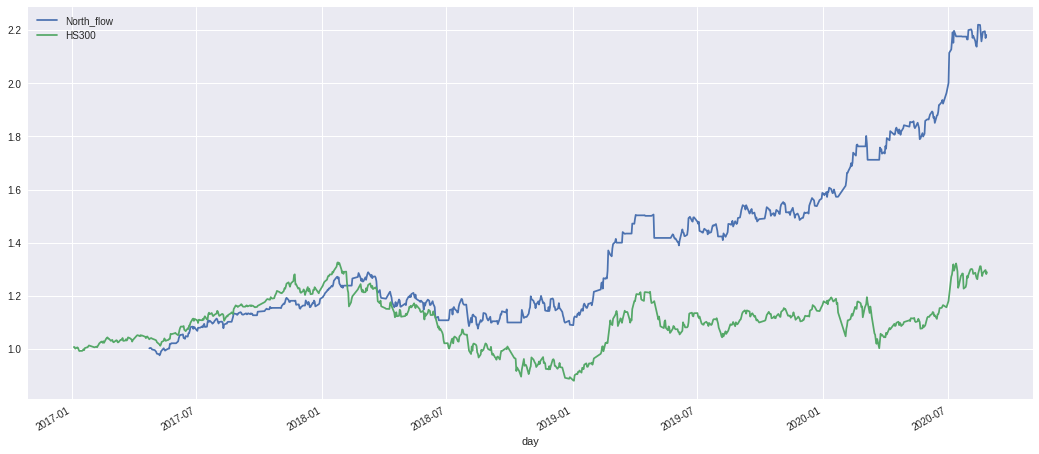

In [16]:
# 使用最优参数构建开平仓 使用最优估计
flag = grid_search.best_estimator_.predict(net_flow)

# 计算收益率
algorithm_ret = flag * ret_ser.shift(-1)

# 画图
np.exp(np.log1p(algorithm_ret).cumsum()).plot(
     figsize=(18, 8), label='North_flow')
    
np.exp(np.log1p(ret_ser).cumsum()).plot(label='HS300')

plt.legend()

In [17]:
# 策略收益
print_table(get_strategy_risk(algorithm_ret).apply(
    lambda x: '{:.2%}'.format(x)))

,风险指标
年化收益率,25.95%
年化波动率,16.09%
最大回撤,-16.46%
Sharpe,164.50%
收益回撤比,157.67%


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.46,2018-03-09,2018-08-16,2019-02-21,250
1,7.72,2019-04-29,2019-06-05,2019-09-03,92
2,4.98,2020-03-04,2020-03-06,2020-04-08,26
3,4.35,2019-11-04,2019-11-28,2019-12-16,31
4,3.99,2019-09-06,2019-09-27,2019-11-01,41


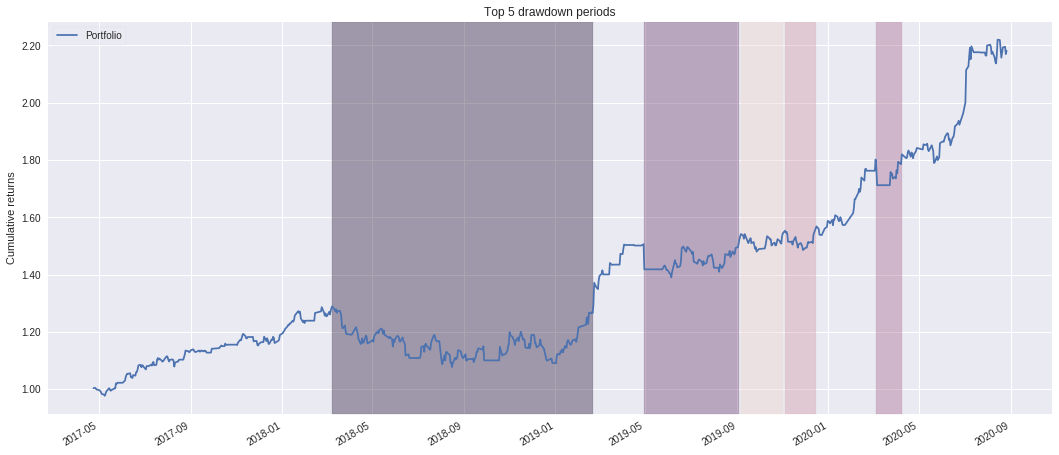

In [19]:
from pyfolio.plotting import (plot_drawdown_periods,
                              show_worst_drawdown_periods)

# 查看前5大回撤区间
show_worst_drawdown_periods(algorithm_ret.dropna(),5)

plt.figure(figsize=(18,8))
plot_drawdown_periods(algorithm_ret.dropna(),5)

## 滚动超参

**超参窗口解释**:起始日为T0,第一次用RandomizedSearchCV进行超参时用90日的窗口期(超参的窗口为T1)进行计算,找到最优参数后用于到未来的10日中(此窗口期为T2),后面每次从T0至t的计算窗口进行超参。

**具体策略逻辑同研报**

In [20]:
# 用于超参
def get_params(X:pd.Series,y:pd.Series,high_limit:int):
    
    norm_rv = st.norm(loc=-0.5, scale=0.45)
    
    randint = st.randint(low=3, high=high_limit)
    
    # 超参设置
    param_grid = {'creatfactor__shortperiod': randint,
                  'creatfactor__longperiod': randint,
                  'backtesting__threshold_h': norm_rv,
                  'backtesting__threshold_l': norm_rv}
    # 构造PIPELINE
    north_factor = Pipeline([('creatfactor', Northflow(5, 10)),
                             ('backtesting', NorthflowStrategy(0.2, -0.1))])

    grid_search = RandomizedSearchCV(
        north_factor, param_grid, n_iter=400, n_jobs=3)

    grid_search.fit(X, y)
    
    return grid_search.best_estimator_

In [21]:
# 每隔10日更新一次参数
basce = 0

window = 90 # 训练窗口
step = 10 # 每10日更新一次参数

length = len(net_flow)
flag_list = []

for i in tqdm_notebook(range(window,length - step,step),desc='计算中'):
    
    X = net_flow.iloc[basce:i]
    y = ret_ser.iloc[basce:i]
    
    if i < 255:
        
        tmp = get_params(X, y,30).predict(net_flow.iloc[basce:i+step])
        
        idx = net_flow.index[i:i+step]
        flag_list.append(tmp.loc[idx])
        
    else:
        
        tmp = get_params(X, y,60).predict(net_flow.iloc[basce:i+step])
        
        idx = net_flow.index[i:i+step]
        flag_list.append(tmp.loc[idx])

计算中: 100%|██████████| 76/76 [11:58<00:00, 12.24s/it]


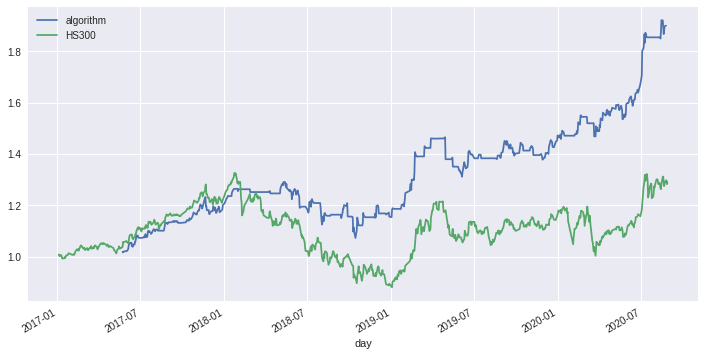

In [22]:
flag_ser = pd.concat(flag_list)

algorithm_ret = flag_ser * ret_ser.reindex(flag_ser.index).shift(-1)
np.exp(np.log1p(algorithm_ret).cumsum()).plot(
    figsize=(12, 6), label='algorithm')
np.exp(np.log1p(ret_ser).cumsum()).plot(label='HS300')
plt.legend()

In [23]:
# 策略收益
print_table(get_strategy_risk(algorithm_ret).apply(
    lambda x: '{:.2%}'.format(x)))

,风险指标
年化收益率,23.71%
年化波动率,14.52%
最大回撤,-16.89%
Sharpe,154.04%
收益回撤比,140.38%


# 组合优化

使用沪深300、中证500、创业板进行回测

In [6]:
start = '2017-01-01'
end = '2020-08-27'

net_flow = get_net_north_flow(start,end)

In [8]:
close_df = get_price(['000300.XSHG', '000905.XSHG',
                      '399006.XSHE'], start, end, fields='close', panel=False)

close_df = pd.pivot_table(close_df, index='time',
                          columns='code', values='close')

pct_chg = close_df.pct_change()

查看沪深300、中证500、创业板未来一周收益率与北流指标的相关系数情况

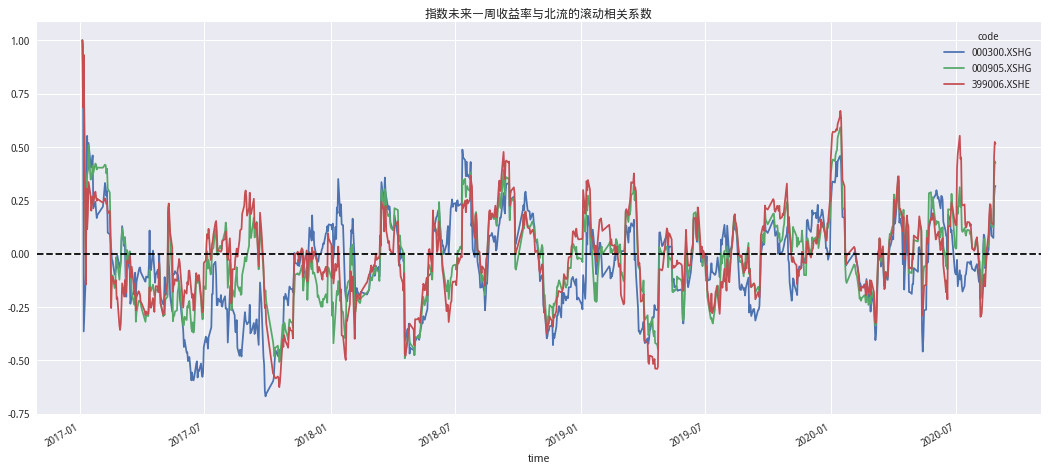

In [17]:
title = '指数未来一周收益率与北流的滚动相关系数'

plt.rcParams['font.family'] = 'serif'

pct_chg.shift(-5).rolling(22,
                          min_periods=1).corr(net_flow).plot(figsize=(18, 8), title=title)
                          
plt.axhline(0, color='black', ls='--')

In [29]:
# 组合优化
from scipy import optimize

def opt_portfolio(algorithm_df:pd.DataFrame,target:str='sharpe') -> list:

    '''组合权重'''
    
    def min_variance(w):return portfolio(algorithm_df, w)[1] ** 2  # 定义一个最小方差函数
    def min_sharpe(w): return - portfolio(algorithm_df, w)[2]
    
    mothod = {'sharpe':min_sharpe,'variance':min_variance}
    # 约束条件，权重总和为1
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
    
    N = algorithm_df.shape[1]
    
    bounds = tuple(itertools.repeat((0,1),N))

    # 夏普率最大
    opt_sharpe = optimize.minimize(mothod[target], weight(N), bounds=bounds,
                                   constraints=cons)
    return opt_sharpe['x']


# 1、定义随机权重函数
def weight(n):
    w = np.random.random(n)
    return w / np.sum(w)


# 2、定义投资组合函数 ，给定收益率和各证券权重，计算组和的年化平均收益率、方差以及sharp率
def portfolio(r: pd.Series, w: np.array, r_f: float = 0.04):

    r_mean = r.mean() * 252  # 各证券的平均年化收益率
    p_mean = r_mean @ w  # 组合平均年化收益率
    r_cov = r.cov() * 252  # 各证券的协方差
    p_var = w.T @ (r_cov @ w)  # 计算组合的方差
    p_std = np.sqrt(p_var)  # 组合标准差
    p_sharpe = (p_mean - r_f) / p_std

    return p_mean, p_std, p_sharpe

这里在上面的策略基础上构建一个新的策略,在沪深300、中证500、创业板中进行超参找到最优参数后用过去N日的收益率进行组合优化,通过优化后的权重分别对三个指数进行配置

In [30]:
# 每隔10日更新一次参数
basce = 0

window = 90 # 训练窗口
step = 10 # 每10日更新一次参数

length = len(net_flow)

hold_list = [] # 持仓

for i in tqdm_notebook(range(window,length - step,step),desc='计算中'):
    
    flag_list = [] # 临时性-开平仓标记
    ret_dic = {} # 临时性-用于组合优化
    
    X = net_flow.iloc[basce:i]
    pct_chg = pct_chg.reindex(net_flow.index)
    
    
    for col_name,col_v in pct_chg.items():

        y = col_v.iloc[basce:i]

        if i < 255:

            tmp = get_params(X, y,30).predict(net_flow.iloc[basce:i+step])
            ret_dic[col_name] = (tmp * y).reindex(y.index)
            idx = net_flow.index[i:i+step]
            ser = tmp.loc[idx]
            ser.name = col_name
            flag_list.append(ser)

        else:

            tmp = get_params(X, y,60).predict(net_flow.iloc[basce:i+step])
            ret_dic[col_name] = (tmp * y).reindex(y.index)
            idx = net_flow.index[i:i+step]
            ser = tmp.loc[idx]
            ser.name = col_name
            flag_list.append(ser)

    ret_df = pd.concat(ret_dic,axis=1)
    
    # 持仓
    hold_list.append(opt_portfolio(ret_df) * pd.concat(flag_list,axis=1))



计算中:   0%|          | 0/76 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中:   3%|▎         | 2/76 [00:38<23:41, 19.21s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中:  18%|█▊        | 14/76 [04:47<22:27, 21.73s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中:  41%|████      | 31/76 [11:37<19:14, 25.65s/it]/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva



计算中:  68%|██████▊   | 52/76 [21:32<12:06, 30.26s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中:  72%|███████▏  | 55/76 [23:06<10:52, 31.05s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中:  80%|████████  | 61/76 [26:22<08:07, 32.53s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中:  84%|████████▍ | 64/76 [28:02<06:36, 33.03s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中:  86%|████████▌ | 65/76 [28:36<06:07, 33.40s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva



计算中:  87%|████████▋ | 66/76 [29:11<05:38, 33.85s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中:  88%|████████▊ | 67/76 [29:45<05:05, 33.97s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中:  99%|█████████▊| 75/76 [34:31<00:35, 35.55s/it]/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: inva

/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


计算中: 100%|██████████| 76/76 [35:07<00:00, 35.80s/it]



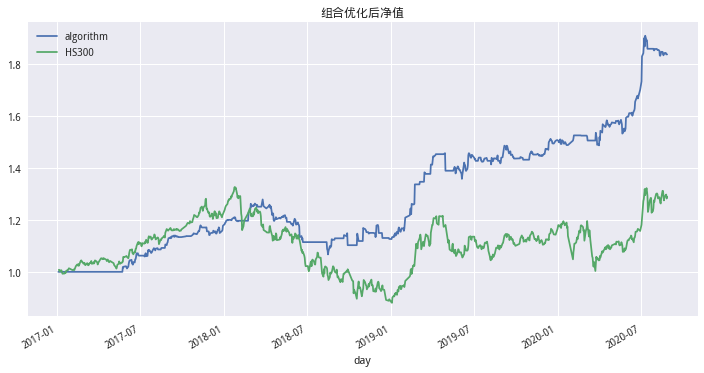

In [34]:
algorithm_ret = pct_chg.shift(-1) * pd.concat(hold_list)


np.exp(np.log1p(algorithm_ret.sum(axis=1)).cumsum()).plot(
    figsize=(12, 6),title='组合优化后净值', label='algorithm')
np.exp(np.log1p(pct_chg['000300.XSHG']).cumsum()).plot(label='HS300')
plt.legend()

由下可知主要收益来源于沪深300,其他指数贡现不大

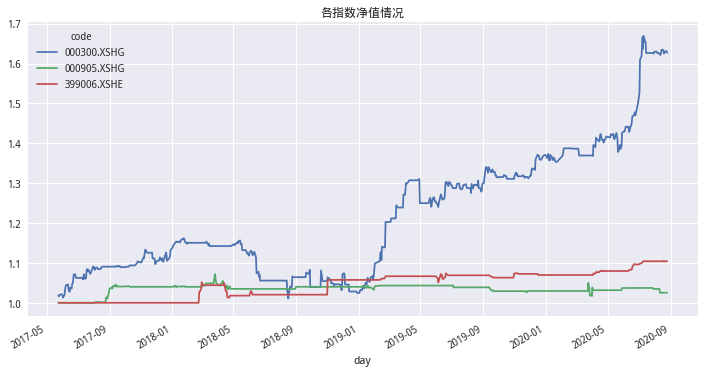

In [35]:
np.exp(np.log1p(algorithm_ret).cumsum()).plot(figsize=(12,6),title='各指数净值情况',label='algorithm')

# 北向资金流具备行业选择的Beta吗

在复现中发现聚宽北向数据中没有北向持股的具体资金数据,如果用**持股数量x个股收盘价**也只是说明当日持仓市值也无法代表自己流入...故行业部分暂时无法进行复现

In [3]:
# 获取北流持仓
start,end = '2017-01-01','2020-09-01'
fields = ['day', 'link_name', 'code', 'name', 'share_number', 'share_ratio']
north_hold = query_north_hold(start, end, fields)

In [4]:
def add_industry(xdf:pd.Series)->pd.Series:
    
    '''标记行业'''
    
    security = xdf.values.tolist()
    day = xdf.name
    ind_dict = get_industry(security, date=day)
    
    return xdf.apply(lambda x:ind_dict[x].get('sw_l1',{'industry_name':np.nan})['industry_name'])



# 添加个股行业
north_hold['industry_name'] = north_hold.groupby('day')['code'].apply(add_industry)

In [5]:
industry_df = north_hold.groupby('day').apply(lambda x:x.groupby('industry_name')['share_ratio'].sum())

查看最近一期北流资金行业分布

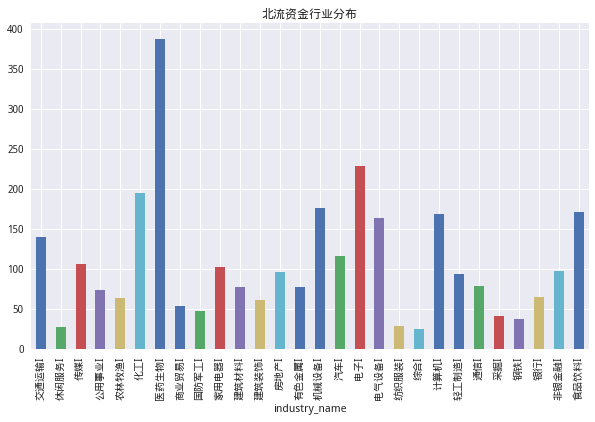

In [59]:
plt.rcParams['font.family'] = 'serif'
industry_df.iloc[-1].plot.bar(title='北流资金行业分布',figsize=(10,6))

## 以持有市值代替资金流入

效果不佳...

In [6]:
# 获取每日收盘价
securities = north_hold['code'].unique().tolist()
start = north_hold['day'].min()
end = north_hold['day'].max()

close_df = get_price(securities,start,end,fields='close',panel=False)

close_df['time'] = close_df['time'].dt.date
close_df = pd.pivot_table(close_df,index='time',columns='code',values='close')

# 北流资金持仓 股数
share_numer = pd.pivot_table(north_hold,index='day',columns='code',aggfunc={'share_number':sum})

valuation =  share_numer * close_df # 计算 股数 * 收盘价

In [9]:
north_hold.head()

,day,link_name,code,name,share_number,share_ratio,industry_name
0,2017-03-17,沪股通,600000.XSHG,浦发银行,102064808,0.49,银行I
1,2017-03-17,沪股通,600004.XSHG,白云机场,49721849,4.32,交通运输I
2,2017-03-17,沪股通,600006.XSHG,东风汽车,1121768,0.05,汽车I
3,2017-03-17,沪股通,600007.XSHG,中国国贸,8305775,0.82,房地产I
4,2017-03-17,沪股通,600008.XSHG,首创股份,46646808,0.96,公用事业I


In [10]:
x_df = pd.concat([north_hold.set_index(['day','code'])['industry_name'],valuation.stack()],axis=1)

w_valuation = x_df.groupby(pd.Grouper(level=0,freq='W')).apply(lambda x:x.groupby('industry_name').sum())

# 行业周度排名
rank_industry = w_valuation.groupby(level=0).apply(lambda x:x.rank(ascending=False))

In [13]:
def query_sw_price(code:str,fields:list,start:str,end:str)->pd.DataFrame:

    '''获取一级行业收盘价'''
    
    if isinstance(fields,str):
        fields = [fields]
        
    select_fields = ','.join(
        [f"finance.SW1_DAILY_PRICE.%s" % i for i in ['date','code','name'] + fields])
    
    q = query(select_fields).filter(finance.SW1_DAILY_PRICE.code == code,
                                    finance.SW1_DAILY_PRICE.date >= start,
                                    finance.SW1_DAILY_PRICE.date <= end)
    
    return finance.run_query(q)

def get_sw_price(fields:list,start:str,end:str)->pd.DataFrame:
    
    sw_code = get_industries('sw_l1').index.tolist()
    
    df_list = []
    
    for code in tqdm_notebook(sw_code,desc='行业数据下载中'):
        
        df_list.append(distributed_query(query_sw_price, start, end, code=code,fields=fields))
        
    df = pd.concat(df_list)
    
    return df

In [15]:
sw_price = get_sw_price(['close'],start,end)
index_df = get_price('000300.XSHG', start, end, fields='close')
ret_ser = np.log1p(index_df['close'] / index_df['close'].shift(1))

In [16]:
sw_price = pd.pivot_table(sw_price,index='date',columns='name',values='close')

# 计算对数收益
sw_ret = np.log(sw_price / sw_price.shift(1))
sw_ret.index = pd.to_datetime(sw_ret.index)

# 周度收益
log_ret = sw_ret.groupby(pd.Grouper(level=0,freq='W')).sum()

In [19]:
r_industry = rank_industry.unstack()
r_industry.columns = r_industry.columns.levels[1]
r_industry.columns = r_industry.columns.map(lambda x:x[:-1])

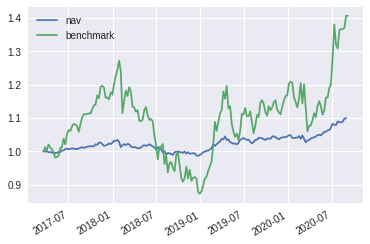

In [56]:
(1+(r_industry < 5) * log_ret.shift(-1).reindex(r_industry.index)).cumprod().mean(axis=1).plot(label='nav')
x_index = index_df['close'].resample('W').last().reindex(r_industry.index)
(x_index / x_index[0]).plot(label='benchmark')
plt.legend()